# AML - Assignment
## Species' locations analysis
This project focuses on mapping and analyzing biodiversity worldwide. Key questions include determining where specific species are found, the diversity present in various locations, and the relationships between species and environmental factors.

### Preliminary code
Some code-behaviour variables are initialized, the useful libraries imported and the main datasets loaded.

In [7]:
# Setting code behaviour variables
GenVISUALS = False      # set to False in order to avoid time-consuming visualizations' genaration (images are instead displayed as pre-saved in 'Outputs' folder)
dpi = 500               # dpi for .pdf-saved images visualization (with GenVISUALS = False)
reCLUSTER = True       # set to False in order to avoid time-consuming clusterings (the relevant data are instead loaded as pre-saved in 'Outputs' folder)
buildNETWORKS = True   # set to False in order to avoid time-consuming species' interactions-network building (the relevant graphs are instead loaded as pre-saved in 'Outputs' folder)
random_seed = 42
# !pip install -r requirements.txt

In [8]:
# Importing useful packages
from pathlib import Path
from pdf2image import convert_from_path
import pickle as pkl
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point, Polygon
from haversine import haversine
import geopandas as gpd
import contextily as ctx
from collections import defaultdict
from sklearn.neighbors import KernelDensity
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, classification_report, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from scipy.stats import kruskal
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [52]:
# Loading data
species_train = np.load(Path('Data/species/species_train.npz'))
species_ids = species_train['taxon_ids'].astype(str)# list of all species' IDs (NB: not necessarily starting at 0 nor 1)
species_names = species_train['taxon_names']        # list of all species' taxon names
species_names = dict(zip(species_ids,species_names))# dictionary of all species' IDs -> taxonomy names
train_dataDF = pd.read_csv(Path('Data/species/species_train.csv'), dtype={'id': str})
#extra_train_dataDF = pd.read_csv(Path('Data/species/species_train_extra.csv'), dtype={'id': str})
test_dataDF = pd.read_csv(Path('Data/species/species_test.csv'), dtype={'id': str})
display(train_dataDF)
#display(extra_train_dataDF)
display(test_dataDF)

,id,lat,long
0,31529,-18.286728,143.481247
1,31529,-13.099798,130.783646
2,31529,-13.965274,131.695145
3,31529,-12.853950,132.800507
4,31529,-12.196790,134.279327
...,...,...,...
271265,145031,33.716885,73.203621
271266,145031,24.600239,72.730560
271267,145031,18.849600,80.654129
271268,145031,21.073837,75.945656


,id,lat,long
0,31529,-19.884237,126.052979
1,31529,-20.219316,124.723953
2,31529,-20.053690,125.386505
3,31529,-19.973000,126.462440
4,31529,-19.962839,124.980362
...,...,...,...
1325748,145031,31.998211,72.541458
1325749,145031,26.927755,69.225052
1325750,145031,23.349318,70.605515
1325751,145031,23.706282,68.259659


### Data exploration and cleaning
The species dataset' main stats are presented.

In [ ]:
# Exploring per-specie records' distribution
id_counts = train_dataDF['id'].value_counts().reset_index()
id_counts.columns = ['id', 'count']
print("Top 5 most and least frequent IDs:")
display(id_counts)
display(id_counts['count'].describe())
total_count = id_counts['count'].sum()
top_5_proportion = id_counts.head(5)['count'].sum() / total_count * 100
print(f"(Top 5 IDs contribute {top_5_proportion:.2f}% of all occurrences)")

if GenVISUALS:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for the number of sightings
    sns.barplot(x=id_counts['id'], y=id_counts['count'], ax=ax1, color='skyblue')
    ax1.set_xlabel('Species ID (ordered by sighting frequency)', fontsize=18)
    ax1.set_ylabel('Number of sightings', fontsize=18)
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-axis ticks

    # Create a second y-axis for the cumulative percentage
    ax2 = ax1.twinx()
    sorted_counts = id_counts['count'].sort_values(ascending=False).values
    cumulative = (np.cumsum(sorted_counts) / total_count) * 100
    ax2.plot(cumulative, color='purple', label='Cumulative Percentage')
    ax2.set_ylabel('Cumulative Percentage (%)', fontsize=18)
    ax2.set_ylim(0, 100)

    plt.savefig(Path('Outputs/ids_distribution.pdf'))
    plt.show()
else:   
    for image in convert_from_path(Path('Outputs/cum_IDs_distribution.pdf'), dpi=dpi):
        display(image)
    for image in convert_from_path(Path('Outputs/IDs_distribution.pdf'), dpi=dpi):
        display(image)

### Animals' distribution
Firstly, the distribution of animals' and individual species' locations is analyzed.

TODO: make the interactive map more readable when zoommed-out

In [ ]:
# Displaying interactive map
interactiveMap = folium.Map(location=[train_dataDF['lat'].mean(), train_dataDF['long'].mean()], zoom_start=5)
locations = list(zip(train_dataDF['lat'], train_dataDF['long']))
HeatMap(locations).add_to(interactiveMap)
interactiveMap

#### Kernel Density Estimate
A KDE model is used to visualize the geographical distribution of the probaility to record animals' presence, thus the same method is applied on the most and least spread species - in terms of locations' variance.

In [ ]:
# 2D kernel density estimate (KDE) function
def kde2D(x, y, bandwidth=3.0, bins=100j, xyMinMax=None): 
    '''
    Given a two-dimensional distribution (x,y), outputs a 2D KDE trained with the input bandwith
    '''

    # Preparing data grid of sample (default: 100x100)
    if xyMinMax == None: xyMinMax = (x.min(),x.max(),y.min(),y.max())
    xx, yy = np.mgrid[xyMinMax[0]:xyMinMax[1]:bins,xyMinMax[2]:xyMinMax[3]:bins]
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    # Training the KDE model
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(xy_train)

    # Returning the log-likelihood of the samples
    z = np.exp(kde.score_samples(xy_sample))
    return (xx, yy, np.reshape(z, xx.shape))

In [ ]:
# KDE of all animals' locations
if GenVISUALS:
    animals_KDE = kde2D(train_dataDF['long'], train_dataDF['lat'], bins=200j)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(*animals_KDE)
    plt.title("Animals' geographical distribution")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.savefig(Path('Outputs/KDE_animals.pdf'))
    plt.show()
else:    
    for image in convert_from_path(Path('Outputs/KDE_animals.pdf'), dpi=dpi):
        display(image)

#### Species' location-variance
The animals are studied based on how much their records are widely distributed. To do so, latitude and longitude should not be considered as two separate columns (e.g., onto which take means individually), but as points mapped onto a higher dimension manifold (i.e., the globe). Hence, a map to cartesian is applied and locations' means are computed, then the data is mapped back; this avoids taking averages on the lower manifold - assuming lat and long are points on a 2D plane.

In [12]:
R = 6371.0 # radius of earth in KM

def latlon_to_cartesian(lat,long):
    lat_rad = math.radians(lat)
    long_rad = math.radians(long)
    x = R * math.cos(lat_rad)*math.cos(long_rad)
    y = R * math.cos(lat_rad)*math.sin(long_rad)
    z = R * math.sin(lat_rad)
    return x,y,z
def cartesian_to_latlon(x,y,z):
    lon = math.atan2(y,x)
    lat = math.atan2(z,R)
    return math.degrees(lat),math.degrees(lon)

# Computing species' location variances
locations_variances = train_dataDF.copy()
locations_variances['x'],locations_variances['y'],locations_variances['z'] = zip(*locations_variances.apply(lambda row: latlon_to_cartesian(row['lat'],row['long']),axis=1))
def calculate_group_stats(group):
    x_centroid = group['x'].mean()
    y_centroid = group['y'].mean()
    z_centroid = group['z'].mean()
    
    centroid_lat,centroid_lon = cartesian_to_latlon(x_centroid,y_centroid,z_centroid)
    centroid = (centroid_lat,centroid_lon)
    
    distances = group.apply(lambda row: haversine((row['lat'],row['long']),centroid),axis=1)
    distance_variance = distances.var()
    return pd.Series({'location_variance': distance_variance, 'centroid': centroid})
locations_variances = locations_variances.groupby('id').apply(calculate_group_stats).sort_values(by='location_variance').reset_index()
locations_variances['canonical'] = locations_variances['id'].map(species_names)
display(locations_variances)

/var/folders/nq/_cp8_y5x5fd8sv7_th97tzs80000gn/T/ipykernel_12891/1145355994.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  locations_variances = locations_variances.groupby('id').apply(calculate_group_stats).sort_values(by='location_variance').reset_index()


,id,location_variance,centroid,canonical
0,25003,6.142108e+01,"(-29.18272013492158, 22.51813729090557)",Breviceps fuscus
1,64387,9.257742e+01,"(20.863512386285308, 114.19166950805456)",Paramesotriton hongkongensis
2,43606,1.000710e+02,"(-17.898696543059362, 48.483638813428236)",Avahi laniger
3,225741,1.293488e+02,"(28.545281008605592, -105.73171923208433)",Neotamias canipes
4,35990,3.780462e+02,"(25.116867846213637, -15.519170623327497)",Gallotia stehlini
...,...,...,...,...
495,4191,1.244489e+07,"(-38.08489994604543, -177.01018872997358)",Phoebetria palpebrata
496,9771,1.261901e+07,"(37.28333002997292, -88.49954532963672)",Pinicola enucleator
497,12716,1.278436e+07,"(33.83833292848528, 10.938091053121898)",Turdus merula
498,4146,1.329410e+07,"(15.826912391347497, -65.60334425453142)",Oceanites oceanicus


In [ ]:
n = 5 # number of most and least location-variant animals to consider
if GenVISUALS:    
    # Extracting locations of top-variant species
    top_n_most_variant = locations_variances.nlargest(n,'location_variance')['id']
    top_n_least_variant = locations_variances.nsmallest(n,'location_variance')['id']
    most_variant_df = train_dataDF[train_dataDF['id'].isin(top_n_most_variant)].copy()
    least_variant_df = train_dataDF[train_dataDF['id'].isin(top_n_least_variant)].copy()
    most_variant_df['geometry'] = most_variant_df.apply(lambda row: Point(row['long'], row['lat']), axis=1)
    least_variant_df['geometry'] = least_variant_df.apply(lambda row: Point(row['long'], row['lat']), axis=1)

    # Displaying most_variant species' distribution
    most_variant_gdf = gpd.GeoDataFrame(most_variant_df, geometry='geometry', crs='EPSG:3857')
    # Projecting GeoDataFrame to Web Mercator (EPSG:3857) for compatibility with contextily
    most_variant_gdf = most_variant_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(20, 12))


    most_variant_gdf.plot(column='id', markersize=10, alpha=0.7, legend=True, ax=ax,  cmap=plt.cm.tab20)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)  # using OpenStreetMap
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.title(f"Top {n} most location-variant species' distribution", fontsize=16)
    plt.savefig(Path('Outputs/most'+str(n)+'_location_variance.pdf'))
    plt.show()

    # Displaying least_variant species' distribution
    least_variant_gdf = gpd.GeoDataFrame(least_variant_df, geometry='geometry', crs='EPSG:4326')
    fig, ax = plt.subplots(figsize=(20, 12))
    least_variant_gdf.plot(column='id', markersize=10, alpha=0.7, legend=True, ax=ax, cmap=plt.cm.tab20)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)  # using OpenStreetMap
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.title(f"Top {n} least location-variant species' distribution", fontsize=16)
    plt.savefig(Path('Outputs/least'+str(n)+'_location_variance.pdf'))
    plt.show()
else:    
    for image in convert_from_path(Path('Outputs/most'+str(n)+'_location_variance.pdf'), dpi=dpi):
        display(image)
    for image in convert_from_path(Path('Outputs/least'+str(n)+'_location_variance.pdf'), dpi=dpi):
        display(image)
        

#### Species Co-occurences - 'Siblings'

In [ ]:
def calculate_kde(df, bandwidth=0.1):
    kde_dict = {}
    unique_species = df['id'].unique()
    for species in unique_species:
        species_data = df[df['id'] == species][['lat', 'long']].values
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(species_data)
        kde_dict[species] = kde
    return kde_dict

kde_dict = calculate_kde(train_dataDF)

In [ ]:
from scipy.spatial.distance import jensenshannon

def calculate_overlap_score(kde1, kde2, grid_size=100):
    lat_range = np.linspace(-90, 90, grid_size)
    long_range = np.linspace(-180, 180, grid_size)
    lat_grid, long_grid = np.meshgrid(lat_range, long_range)
    grid_points = np.vstack([lat_grid.ravel(), long_grid.ravel()]).T 

    kde1_values = np.exp(kde1.score_samples(grid_points))
    kde2_values = np.exp(kde2.score_samples(grid_points))

    kde1_values /= kde1_values.sum()
    kde2_values /= kde2_values.sum()

    overlap_score = jensenshannon(kde1_values, kde2_values)
    return overlap_score

def find_top_k_cooccurring_species(kde_dict, target_species_id, k=3, bandwidth=0.1, grid_size=100):
    target_kde = kde_dict.get(target_species_id)
    if target_kde is None:
        print(f"Species ID {target_species_id} not found.")
        return []

    overlap_scores = []
    for species_id, kde in kde_dict.items():
        if species_id != target_species_id:
            score = calculate_overlap_score(target_kde, kde, grid_size)
            overlap_scores.append((species_id, score))

    # Rank in descending order, since we want to find the 'closest' matches
    overlap_scores.sort(key=lambda x: x[1]) 
    top_k_species = overlap_scores[:k]
    
    return top_k_species

In [ ]:
top_k_species = find_top_k_cooccurring_species(kde_dict, target_species_id='31529', k=1)
print("Top K co-occurring species with overlap scores:", top_k_species)

#### Top 10 co-occuring species overall

In [ ]:
# # We don't need to re-run this, but keeping it for record
# species_ids = list(sorted(kde_dict.keys()))

# start_index = 0
# end_index = 500

# with open('Outputs/co-occuring.csv', mode='a') as csvfile:
#     for id in species_ids[start_index:end_index]:
#         top_k_species = find_top_k_cooccurring_species(kde_dict, target_species_id=id, k=5)
#         for (id_2, score) in top_k_species:
#             csvfile.write(f"{id}, {id_2}, {score}\n")
#         print(f"Done for {id}")


co_occuringDF = pd.read_csv('Outputs/co-occuring.csv')
co_occuringDF.columns = ['id', 'sibling_id', 'score']
co_occuringDF = co_occuringDF.astype({'id': str, 'sibling_id': str})

# To get rid of mirrored (id, sibling_id) and (sibling_id, id) entries
co_occuringDF['pair'] = co_occuringDF.apply(lambda row: tuple(sorted([row['id'], row['sibling_id']])), axis=1)
co_occuringDF = co_occuringDF.drop_duplicates(subset=['pair', 'score']).drop(columns='pair').sort_values('score')
display(co_occuringDF.head(10))

#### Compute 'Siblings' for top N most/least variant species

In [ ]:
N_variant_species = 10
top_n_most_variant = locations_variances.nlargest(N_variant_species,'location_variance')

top_n_most_variant['sibling'] = top_n_most_variant.apply(lambda row: find_top_k_cooccurring_species(kde_dict, target_species_id=row['id'], k=1), axis=1)

display(top_n_most_variant)


In [ ]:
top_n_least_variant = locations_variances.nsmallest(N_variant_species, 'location_variance')

top_n_least_variant['sibling'] = top_n_least_variant.apply(lambda row: find_top_k_cooccurring_species(kde_dict, target_species_id=row['id'], k=1), axis=1)

display(top_n_least_variant)

In [ ]:
# KDE of specific species' distribution
for specie in [locations_variances.iloc[0],locations_variances.iloc[-1]]:
    if GenVISUALS:
        specie_KDE = kde2D(train_dataDF[train_dataDF['id']==specie['id']]['long'].to_numpy(), train_dataDF[train_dataDF['id']==specie['id']]['lat'].to_numpy(), bins=100j, xyMinMax=(-175,175,-70,70))
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(*specie_KDE)
        plt.title("Geographical distribution of "+specie['canonical'])
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.savefig(Path('Outputs/KDE'+str(specie['id'])+'.pdf'))
        plt.show()
    else:    
        for image in convert_from_path(Path('Outputs/KDE'+str(specie['id'])+'.pdf'), dpi=dpi):
            display(image)

### Test Distribution comparison

In [53]:
locations_variances_test = test_dataDF.copy()
locations_variances_test['x'],locations_variances_test['y'],locations_variances_test['z'] = zip(*locations_variances_test.apply(lambda row: latlon_to_cartesian(row['lat'],row['long']),axis=1))
def calculate_group_stats(group):
    x_centroid = group['x'].mean()
    y_centroid = group['y'].mean()
    z_centroid = group['z'].mean()
    
    centroid_lat,centroid_lon = cartesian_to_latlon(x_centroid,y_centroid,z_centroid)
    centroid = (centroid_lat,centroid_lon)
    
    distances = group.apply(lambda row: haversine((row['lat'],row['long']),centroid),axis=1)
    distance_variance = distances.var()
    return pd.Series({'location_variance': distance_variance, 'centroid': centroid})
locations_variances_test = locations_variances_test.groupby('id').apply(calculate_group_stats).sort_values(by='location_variance').reset_index()
locations_variances_test['canonical'] = locations_variances_test['id'].map(species_names)
display(locations_variances_test)

/var/folders/nq/_cp8_y5x5fd8sv7_th97tzs80000gn/T/ipykernel_12891/528650143.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  locations_variances_test = locations_variances_test.groupby('id').apply(calculate_group_stats).sort_values(by='location_variance').reset_index()


,id,location_variance,centroid,canonical
0,25003,3.482064e+02,"(-29.199746818489352, 22.712630478628792)",Breviceps fuscus
1,35990,8.875192e+02,"(25.208013789289847, -15.53125969254562)",Gallotia stehlini
2,6364,9.326582e+02,"(9.309543686001225, -83.47034599763495)",Selasphorus flammula
3,9477,1.267554e+03,"(-0.5543698641745232, -90.82177967377034)",Geospiza magnirostris
4,73903,1.285539e+03,"(29.874643337327072, 33.34871135365417)",Phoenicolacerta troodica
...,...,...,...,...
495,4636,8.279555e+06,"(-2.9358974750354174, 129.21540299452238)",Fregata minor
496,145300,9.319196e+06,"(38.8659147491994, 91.94713010766215)",Acanthis flammea
497,12716,1.104233e+07,"(30.9103426053193, 37.42522251575538)",Turdus merula
498,4146,1.687863e+07,"(-13.057305213866115, 77.35818396551844)",Oceanites oceanicus


In [55]:
def compare_species_dataframes(df1, df2, distance_threshold=100, variance_threshold=0.1):
    results = []

    for species_id in df1['id']:
        row1 = df1[df1['id'] == species_id].iloc[0]
        row2 = df2[df2['id'] == species_id].iloc[0]

        distance = haversine(row1['centroid'], row2['centroid'])

        variance_diff = abs(row1['location_variance'] - row2['location_variance'])

        distance_significant = distance > distance_threshold
        variance_significant = variance_diff > variance_threshold

        # Append result
        results.append({
            'id': species_id,
            'distance': distance,
            'variance_diff': variance_diff,
            'distance_significant': distance_significant,
            'variance_significant': variance_significant
        })

    # Convert to DataFrame
    comparison_df = pd.DataFrame(results)
    return comparison_df

In [ ]:
comparison_DF = compare_species_dataframes(locations_variances, locations_variances_test, distance_threshold=100, variance_threshold=0.3)
display(comparison_DF[comparison_DF['distance_significant']])

,id,distance,variance_diff,distance_significant,variance_significant
2,43606,188.476289,1.166581e+04,True,True
14,93486,191.679166,6.985554e+03,True,True
19,6228,257.079523,9.003645e+03,True,True
20,24994,126.382366,3.885022e+03,True,True
24,12953,128.655130,3.532170e+03,True,True
...,...,...,...,...,...
495,4191,6511.510497,8.119737e+06,True,True
496,9771,7216.119345,9.678867e+06,True,True
497,12716,2501.686262,1.742033e+06,True,True
498,4146,16019.839808,3.584530e+06,True,True


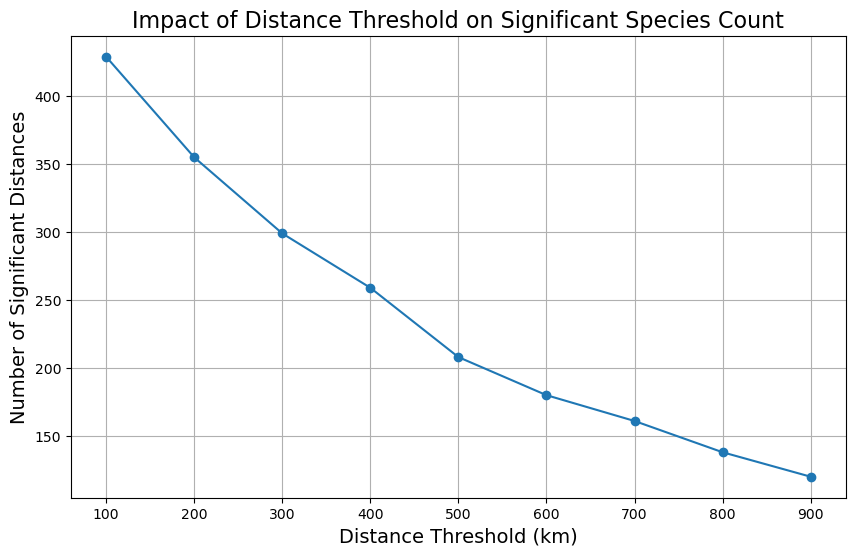

In [ ]:
threshold_vs_significant_count = []

# Iterate over distance thresholds
for distance_threshold in range(100, 1000, 100):
    # Compute the comparison DataFrame
    comparison_DF = compare_species_dataframes(
        locations_variances, 
        locations_variances_test, 
        distance_threshold=distance_threshold, 
        variance_threshold=0.3
    )
    
    # Count rows where distance is significant
    significant_count = len(comparison_DF[comparison_DF['distance_significant']])
    
    # Store the threshold and count
    threshold_vs_significant_count.append((distance_threshold, significant_count))

results_df = pd.DataFrame(
    threshold_vs_significant_count, 
    columns=['distance_threshold', 'significant_count']
)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df['distance_threshold'], results_df['significant_count'], marker='o', linestyle='-')
plt.xlabel("Distance Threshold (km)", fontsize=14)
plt.ylabel("Number of Significant Distances", fontsize=14)
plt.title("Impact of Distance Threshold on Significant Species Count", fontsize=16)
plt.grid()
plt.show()

In [71]:
scaling_factor = 2
locations_variances['distance_threshold'] = scaling_factor * np.sqrt(locations_variances['location_variance'])
locations_variances_test['distance_threshold'] = scaling_factor * np.sqrt(locations_variances_test['location_variance'])

In [75]:
def compare_species_dataframes_with_specific_thresholds(df1, df2):
    results = []
    
    for _, row1 in df1.iterrows():
        species_id = row1['id']
        centroid1 = row1['centroid']
        threshold1 = row1['distance_threshold']
        
        row2 = df2[df2['id'] == species_id]
        if not row2.empty:
            centroid2 = row2.iloc[0]['centroid']
            
            distance = haversine(centroid1, centroid2)
            is_significant = distance > threshold1
            
            results.append({
                'id': species_id,
                'distance': distance,
                'distance_threshold_1': threshold1,
                'distance_significant': is_significant
            })
    
    return pd.DataFrame(results)

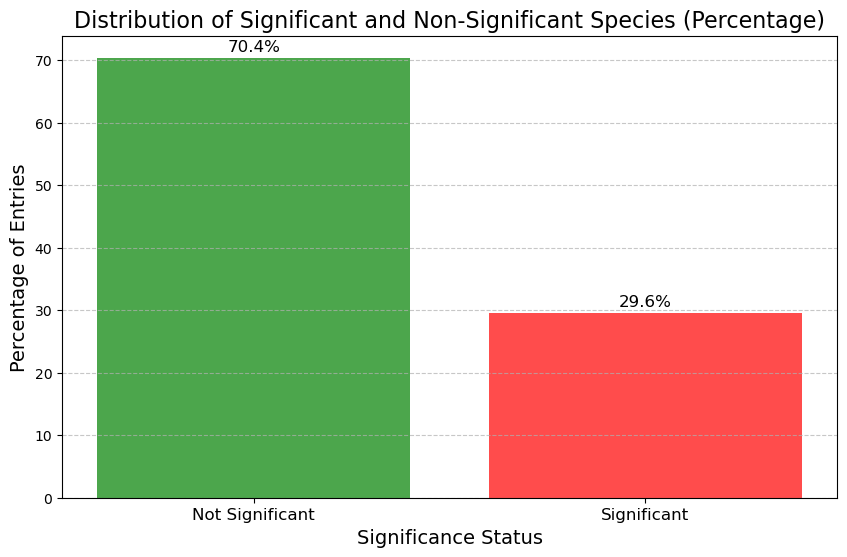

In [83]:
comparison_species_specific_DF = compare_species_dataframes_with_specific_thresholds(
        locations_variances, 
        locations_variances_test,
    )

test_dataDF['is_significant'] = test_dataDF['id'].map(
    comparison_species_specific_DF.set_index('id')['distance_significant']
)

significant_counts = test_dataDF['is_significant'].value_counts()
total_count = significant_counts.sum()
significant_percentages = (significant_counts / total_count) * 100

# Plotting as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(significant_counts.index, significant_percentages.values, color=['green', 'red'], alpha=0.7)

# Annotating the bars with percentages
for bar, percentage in zip(bars, significant_percentages.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        bar.get_height() + 1,              # Slightly above the bar
        f"{percentage:.1f}%",             # Format as a percentage
        ha='center', fontsize=12
    )

# Adding labels and title
plt.xticks(ticks=[0, 1], labels=['Not Significant', 'Significant'], fontsize=12)
plt.xlabel("Significance Status", fontsize=14)
plt.ylabel("Percentage of Entries", fontsize=14)
plt.title("Distribution of Significant and Non-Significant Species (Percentage)", fontsize=16)

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

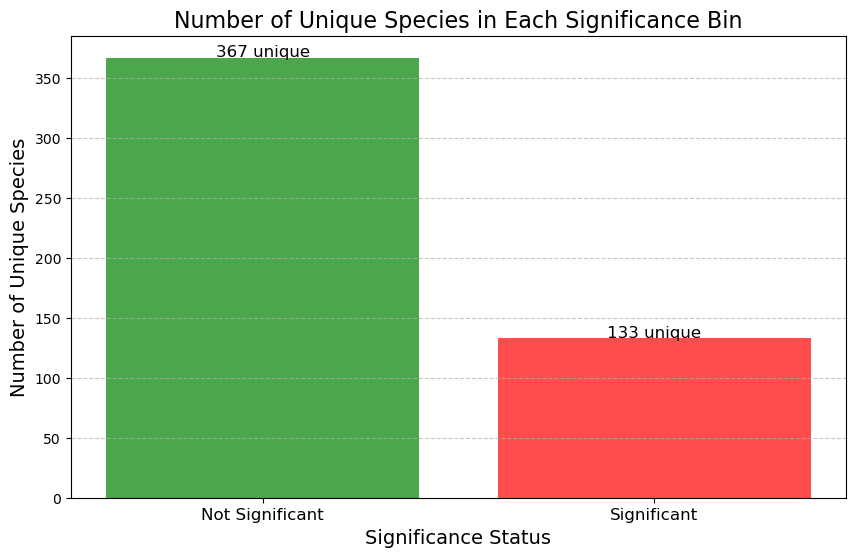

In [84]:
unique_species_counts = test_dataDF.groupby('is_significant')['id'].nunique()

# Plotting as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_species_counts.index, unique_species_counts.values, color=['green', 'red'], alpha=0.7)

# Annotating the bars with counts
for bar, count in zip(bars, unique_species_counts.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        bar.get_height() + 1,              # Slightly above the bar
        f"{count} unique",                 # Display unique count
        ha='center', fontsize=12
    )

# Adding labels and title
plt.xticks(ticks=[0, 1], labels=['Not Significant', 'Significant'], fontsize=12)
plt.xlabel("Significance Status", fontsize=14)
plt.ylabel("Number of Unique Species", fontsize=14)
plt.title("Number of Unique Species in Each Significance Bin", fontsize=16)

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/nq/_cp8_y5x5fd8sv7_th97tzs80000gn/T/ipykernel_12891/622909202.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


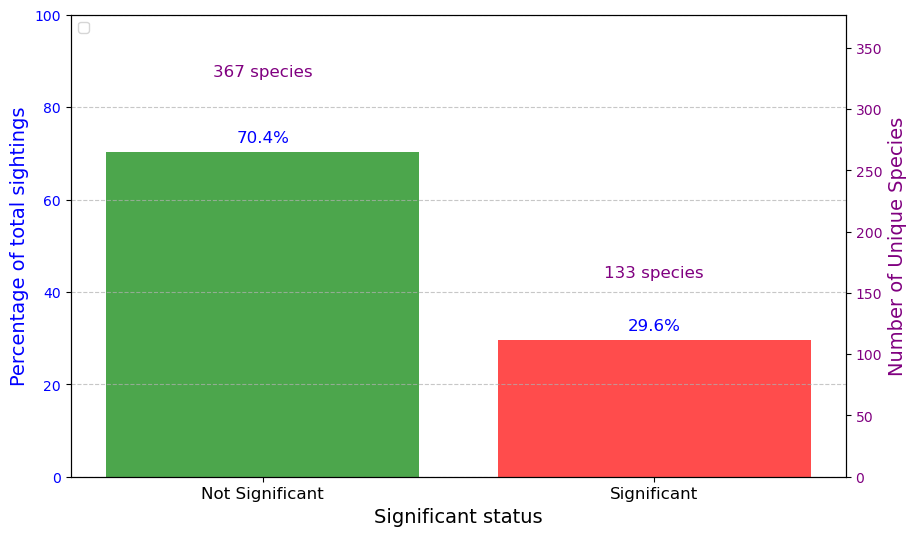

In [139]:
import matplotlib.pyplot as plt

# Count occurrences and calculate percentages
significant_counts = test_dataDF['is_significant'].value_counts()
total_count = significant_counts.sum()
significant_percentages = (significant_counts / total_count) * 100

# Count unique species_id in each bin
unique_species_counts = test_dataDF.groupby('is_significant')['id'].nunique()

# Create the figure and the first y-axis for percentages
fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(significant_counts.index, significant_percentages.values, color=['green', 'red'], alpha=0.7)
ax1.set_ylabel("Percentage of total sightings", fontsize=14, color='blue')
ax1.set_ylim(0, 100)  # Percentages range from 0 to 100
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel("Significant status", fontsize=14)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Not Significant', 'Significant'], fontsize=12)

# Annotate bars with percentages
for bar, percentage in zip(bars, significant_percentages.values):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        f"{percentage:.1f}%",
        ha='center',
        fontsize=12,
        color='blue'
    )

# Create a second y-axis for unique species counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Unique Species", fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(0, unique_species_counts.max() + 10)  # Adjust the range to fit the data

# Annotate unique species counts
for x, y in zip(unique_species_counts.index, unique_species_counts.values):
    if y == 133:
        ax2.text(
        x, y + 30,
        f"{y} species",
        ha='center',
        fontsize=12,
        color='purple'
        )
    else:
        ax2.text(
            x, y - 40,
            f"{y} species",
            ha='center',
            fontsize=12,
            color='purple'
        )

# Add grid and show the plot
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()


<!-- ### Regions identification
Basing on the longitude and latitude data only, some geographical areas are defined by clustering, thus the species' presence isolated in these regions. -->

#### Decision-tree-based clustering
A specie-classifying decision tree is used on longitude and latitude data and then cut to a sensible depth. This would lead to the extraction of a locations' clustering: the groups of longitude and latitude couples obtained in the leaf nodes - enriched by the list of thereby present species - could be conceived as geographical regions of which fauna can be studied separately.

In [ ]:
if reCLUSTER:
    # Preparing data (with splitting for validation purpose)
    label_encoder = LabelEncoder()
    encoded_train_dataDF = train_dataDF.copy()
    encoded_train_dataDF['species_encoded'] = label_encoder.fit_transform(encoded_train_dataDF['id'])
    X = encoded_train_dataDF[['lat', 'long']]
    y = encoded_train_dataDF['species_encoded']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    # Training classifier
    tree_model = DecisionTreeClassifier(random_state=random_seed, max_depth=8)
    tree_model.fit(X_train, y_train)

    # Gauging accuracy on validation set
    y_pred = tree_model.predict(X_val)
    y_test_labels = label_encoder.inverse_transform(y_val)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    target_names = [str(class_name) for class_name in label_encoder.classes_]
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    report = classification_report(y_test_labels, y_pred_labels, target_names=target_names,zero_division=0.0,output_dict=True)
    print("Classification Report:")
    for metric in ['accuracy','macro avg','weighted avg']:
        print(metric+":", report[metric])

    # Testing the species' presence prediction for a location example
    LAT,LONG = 40.7128,-74.0060
    print(f"Predicted species for location ({LAT},{LONG}):", label_encoder.inverse_transform(tree_model.predict(pd.DataFrame([[LAT, LONG]], columns=['lat','long'])))[0])
    
    # Plotting the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree_model, feature_names=['lat', 'long'], class_names=target_names, filled=True, rounded=True)
    plt.title(f"Specie-classification location-based Decision Tree (acc: {report['accuracy']})")
    plt.savefig(Path('Outputs/LocationsDT.pdf'))
    plt.show()

else:
    for image in convert_from_path(Path('Outputs/LocationsDT.pdf'), dpi=dpi):
        display(image)

In [ ]:
if reCLUSTER:
    def get_depth_entropy(node_id,current_depth,data):
        '''
        Recursive function to calculate depth and gather entropy values
        '''
        # Current depth info
        entropy = tree_model.tree_.impurity[node_id]
        data[current_depth].append(entropy)

        # Recursion to both child nodes until leaf is reached
        if tree_model.tree_.children_left[node_id] != -1:
            get_depth_entropy(tree_model.tree_.children_left[node_id],current_depth+1,data)
        if tree_model.tree_.children_right[node_id] != -1:
            get_depth_entropy(tree_model.tree_.children_right[node_id],current_depth+1,data)

    # Calculating average entropy at each depth level
    depth_entropy = defaultdict(list)
    get_depth_entropy(0,0,depth_entropy) # recursive function activation starting from root node
    depths = sorted(depth_entropy.keys())
    average_entropy = [np.mean(depth_entropy[depth]) for depth in depths]

    # Plotting entropy at each depth
    plt.figure(figsize=(10, 6))
    plt.plot(depths, average_entropy, marker='o', linestyle='-')
    plt.xlabel("Tree Depth")
    plt.ylabel("Average Entropy")
    plt.title("Average Entropy at Each Depth Level in the Decision Tree")
    plt.savefig(Path('Outputs/EntropyDT.pdf'))
    plt.show()
    
else:
    for image in convert_from_path(Path('Outputs/EntropyDT.pdf'), dpi=dpi):
        display(image)

In [ ]:
if reCLUSTER:
    def find_leaf_for_location(tree_model,latitude,longitude,info=False):
        '''
        Function to get the relevant leaf (and eventually its stats) given a location
        '''
        # Extracting the relevant leaf's index
        sample = pd.DataFrame([[latitude, longitude]], columns=["lat", "long"])
        leaf_index = tree_model.apply(sample)[0]
        output = leaf_index

        # Eventually adding leaf's information to output
        if info:
            tree = tree_model.tree_
            leaf_impurity = tree.impurity[leaf_index]
            leaf_samples = tree.n_node_samples[leaf_index]
            output = {'index':leaf_index,'impurity':leaf_impurity,'samples':leaf_samples}
            
        return output

    # Testing leaf retreival for a location example
    LAT,LONG = 40.7128,-74.0060
    print(f"Leaf info for location ({LAT},{LONG}): {find_leaf_for_location(tree_model,LAT,LONG,info=True)}\n")

    # Assigning each location to a tree-obtained geographical cluster
    clustered_train_dataDF = train_dataDF.copy()
    clustered_train_dataDF['geoCluster'] = clustered_train_dataDF.apply(lambda row: find_leaf_for_location(tree_model, row['lat'], row['long']), axis=1)
    print(clustered_train_dataDF['geoCluster'].value_counts())
    display(clustered_train_dataDF)

### Incorporating bioclimatic data
Data about the environmental factors are loaded and explored; this information set would be useful afterwards to develop more efficient species' presence predictive models.

**Variables of interest:**
- BIO1: Annual Mean Temperature
- BIO5: Max Temperature of Warmest Month
- BIO6: Min Temperature of Coldest Month
- BIO12: Annual Precipitation
- BIO15: Precipitation Seasonality (Coefficient of Variation)

In [108]:
# Loading bioclimatic data
bioclimatic_variables = ['BIO1', 'BIO5', 'BI06', 'BIO12', 'BIO15']
bioclimatic_train = pd.read_csv(Path('Data/bioclimatic/cleaned_bioclimatic_train.csv'), dtype={'id': str})
display(bioclimatic_train)
# bioclimatic_test = pd.read_csv(Path('Data/bioclimatic/cleaned_bioclimatic_test.csv'), dtype={'id': str})

# Considering individual latitude-longitude couples
unique_bioclimatic_train = bioclimatic_train.drop_duplicates(subset=['lat', 'long']).copy()
unique_bioclimatic_train.describe()
print(unique_bioclimatic_train.shape)

,id,lat,long,BIO1,BIO5,BI06,BIO12,BIO15
0,31529,-18.286728,143.481247,25.830833,36.812252,12.26175,778.0,118.931313
1,31529,-13.099798,130.783646,26.970772,35.256001,15.94425,1637.0,106.943298
2,31529,-13.965274,131.695145,27.042313,37.103500,15.02150,1190.0,112.085449
3,31529,-12.853950,132.800507,27.847281,36.489750,17.33075,1438.0,111.659103
4,31529,-12.196790,134.279327,27.310499,35.029251,18.08950,1250.0,112.806938
...,...,...,...,...,...,...,...,...
271265,145031,33.716885,73.203621,20.198093,36.904251,3.22975,1087.0,85.595444
271266,145031,24.600239,72.730560,23.997032,37.051250,9.97050,1013.0,166.995056
271267,145031,18.849600,80.654129,26.365208,39.693748,13.54425,1547.0,135.629791
271268,145031,21.073837,75.945656,27.160301,41.581749,13.43450,735.0,124.973358


(238145, 8)


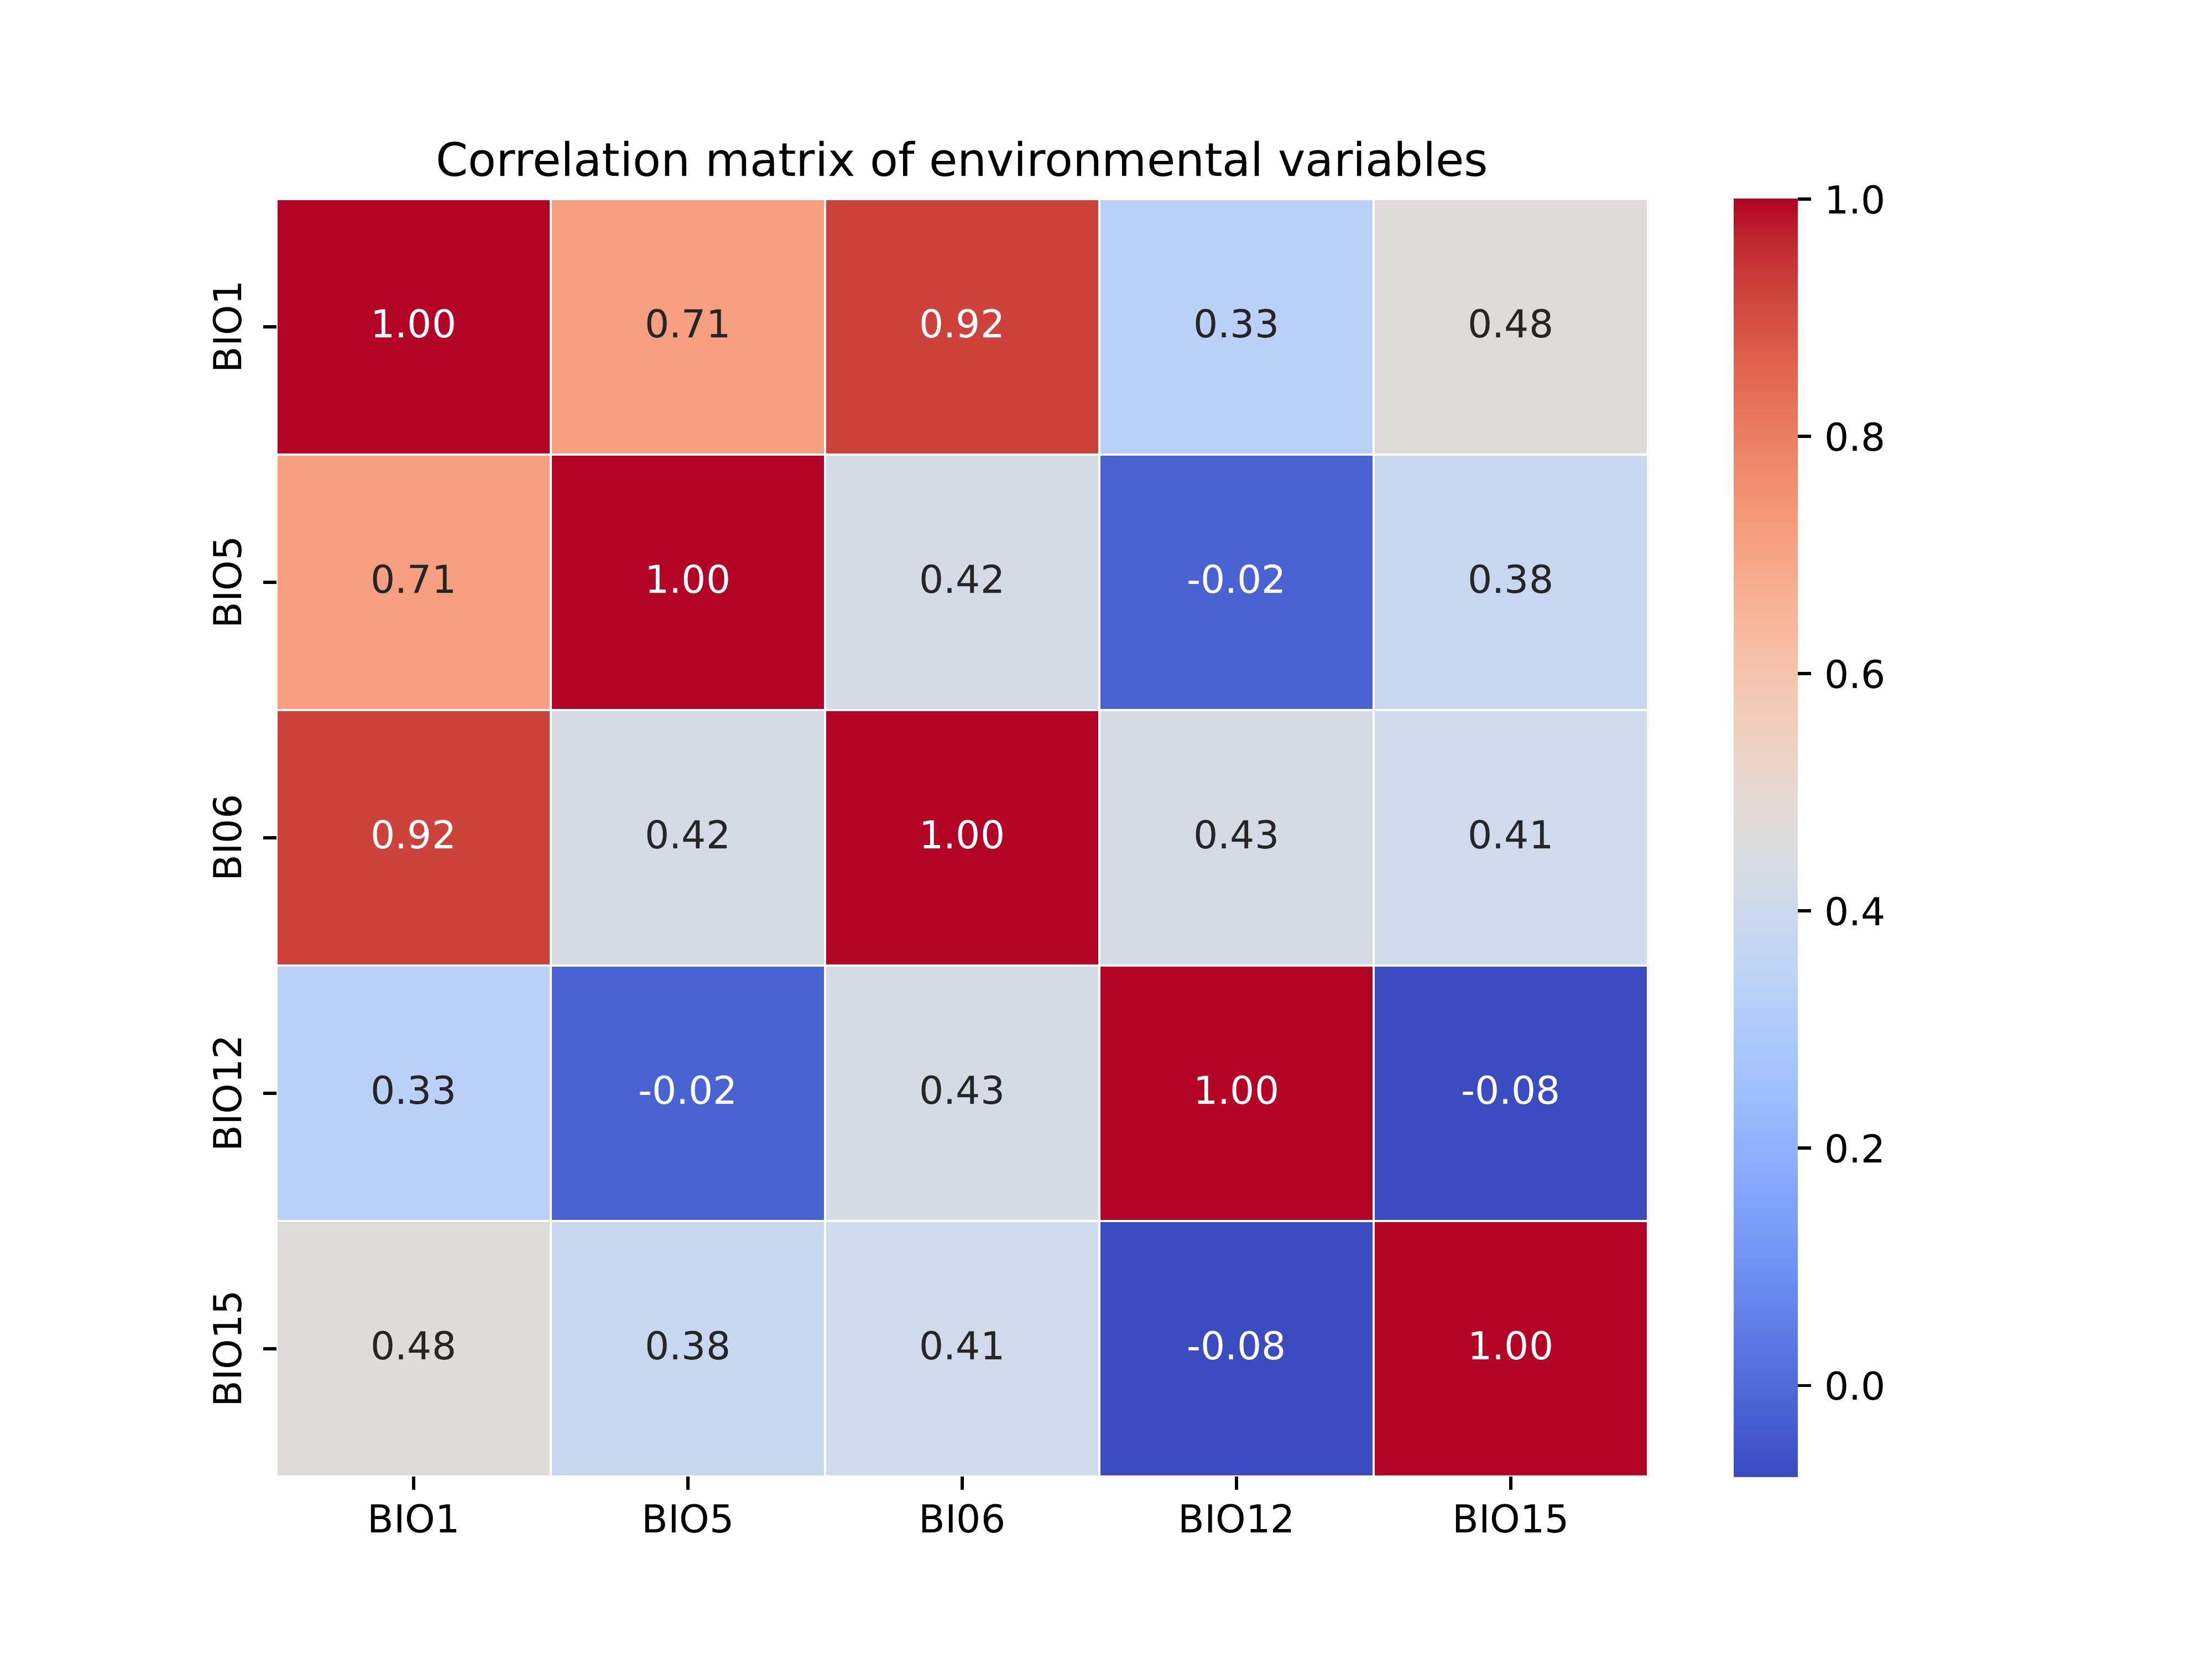

In [109]:
# Considering environmental variables' correlation
if GenVISUALS:
    correlation_matrix = bioclimatic_train[bioclimatic_variables].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation matrix of environmental variables")
    plt.savefig(Path('Outputs/biocliamtic_vars_correlation.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/biocliamtic_vars_correlation.pdf'), dpi=dpi):
        display(image)

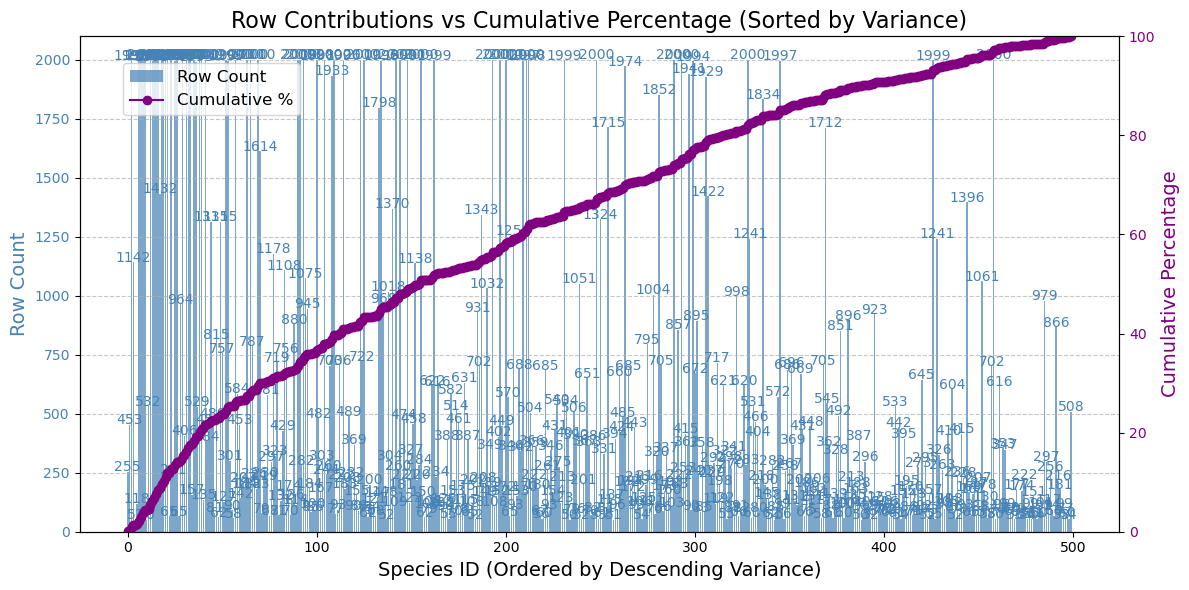

In [111]:
# Compute variance for each bioclimatic variable grouped by 'id'
variance_df = bioclimatic_train.groupby('id')[['BIO1', 'BIO5', 'BI06', 'BIO12', 'BIO15']].var().reset_index()

# Count the number of rows contributed by each 'id'
row_counts = bioclimatic_train['id'].value_counts().reset_index()
row_counts.columns = ['id', 'row_count']

# Merge the variance and row count information
variance_df = variance_df.merge(row_counts, on='id')

# Sort by descending order of variance for a chosen variable (e.g., BIO1)
variance_df = variance_df.sort_values(by='BIO1', ascending=False).reset_index(drop=True)

# Calculate cumulative percentages for row contributions
variance_df['cumulative_percentage'] = (variance_df['row_count'].cumsum() / variance_df['row_count'].sum()) * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for row contributions
bars = ax1.bar(variance_df.index, variance_df['row_count'], alpha=0.7, label="Row Count", color="steelblue")
ax1.set_xlabel("Species ID (Ordered by Descending Variance)", fontsize=14)
ax1.set_ylabel("Row Count", fontsize=14, color="steelblue")
ax1.tick_params(axis='y', labelcolor="steelblue")

# Annotate bars with row counts
for bar, count in zip(bars, variance_df['row_count']):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f"{count}", ha='center', fontsize=10, color='steelblue')

# Line plot for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(variance_df.index, variance_df['cumulative_percentage'], color='purple', label="Cumulative %", marker='o', linestyle='-')
ax2.set_ylabel("Cumulative Percentage", fontsize=14, color="purple")
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim(0, 100)

# Add grid and titles
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Row Contributions vs Cumulative Percentage (Sorted by Variance)", fontsize=16)

# Legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=12)
plt.tight_layout()

plt.show()


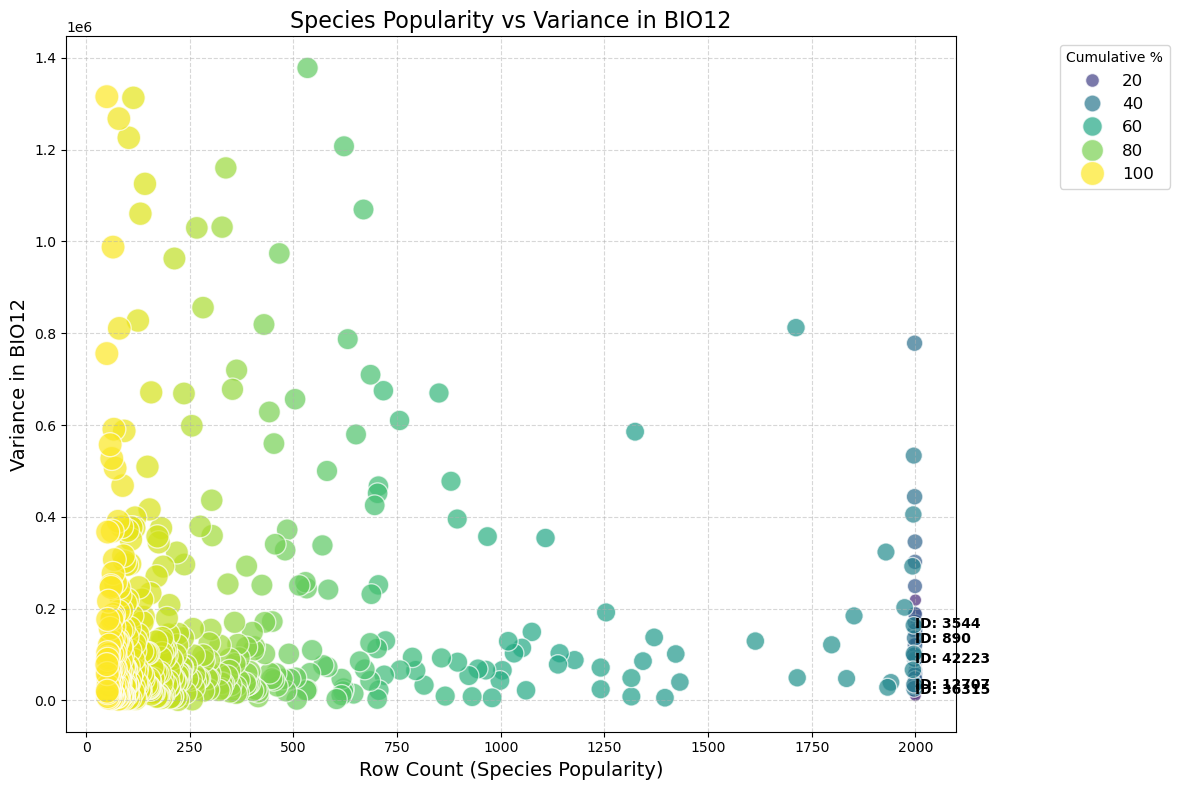

In [140]:
# Choose the column to analyze (e.g., 'BIO1')
column_to_analyze = 'BIO12'

# Sort the DataFrame by row_count to ensure clear visualization
variance_df = variance_df.sort_values(by='row_count', ascending=False)

# Scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=variance_df['row_count'],
    y=variance_df[column_to_analyze],
    size=variance_df['cumulative_percentage'],  # Size indicates cumulative row percentage
    hue=variance_df['cumulative_percentage'],  # Color gradient based on cumulative percentage
    palette='viridis',
    sizes=(50, 300),  # Scale of the point sizes
    alpha=0.7,
    edgecolor="w"
)

# Customizing the plot
plt.title(f"Species Popularity vs Variance in {column_to_analyze}", fontsize=16)
plt.xlabel("Row Count (Species Popularity)", fontsize=14)
plt.ylabel(f"Variance in {column_to_analyze}", fontsize=14)
plt.legend(title="Cumulative %", loc='upper right', fontsize=12, bbox_to_anchor=(1.25, 1))
plt.grid(True, linestyle='--', alpha=0.5)

# Adding annotations for top 5 most popular species
for _, row in variance_df.nlargest(5, 'row_count').iterrows():
    plt.text(
        row['row_count'],
        row[column_to_analyze],
        f"ID: {row['id']}",
        fontsize=10,
        color="black",
        weight="bold"
    )

plt.tight_layout()
plt.show()


#### Environment-based locations clustering
The above bioclimatic data are used to obtain a grouping of the relevant locations by environmetal features.

In [ ]:
if reCLUSTER:
    # K-means on bioclimatic data
    kRANGE = range(2, 15)

    # Scaling
    scaler = StandardScaler()
    scaled_unique_bioclimatic_train = scaler.fit_transform(unique_bioclimatic_train)

    # Evaluating all k values
    inertias = []
    for k in kRANGE:
        kmeans = KMeans(n_clusters=k, random_state=random_seed, n_init=10)
        kmeans.fit(scaled_unique_bioclimatic_train)
        inertias.append(kmeans.inertia_)

    # Ploting inertia vs k
    plt.figure(figsize=(8, 5))
    plt.plot(kRANGE, inertias, marker='o')
    plt.title("Elbow method: optimal number of bioclimatic clusters")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.savefig(Path('Outputs/InertiaBioclimaticClusterings.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/InertiaBioclimaticClusterings.pdf'), dpi=dpi):
        display(image)

In [ ]:
if reCLUSTER:
    # Running optimal K-means
    kOPTIMAL = 5  # chosen through elbow plot

    # Assigning locations to environmental clusters
    kmeans = KMeans(n_clusters=kOPTIMAL, random_state=random_seed, n_init=10)
    unique_bioclimatic_train['bioclimaticCluster'] = kmeans.fit_predict(unique_bioclimatic_train)
    print(unique_bioclimatic_train['bioclimaticCluster'].value_counts(),"\n")

    # Subdividing the biggest cluster (i.e., '0')
    largest_cluster = unique_bioclimatic_train[unique_bioclimatic_train['bioclimaticCluster'] == 0].copy()
    sub_kmeans = KMeans(n_clusters=2, random_state=random_seed, n_init=10)
    sub_clusters = sub_kmeans.fit_predict(largest_cluster)
    unique_bioclimatic_train.loc[largest_cluster.index,'bioclimaticCluster'] = np.where(sub_clusters == 0, 0, 5).astype(np.int32)
    print(unique_bioclimatic_train['bioclimaticCluster'].value_counts())

    # Merging and displaying the cluster information dataframe
    bioclimatic_trainDF = pd.merge(unique_bioclimatic_train[['id', 'lat', 'long', 'bioclimaticCluster']], bioclimatic_train[['lat', 'long', 'BIO1', 'BIO5', 'BI06', 'BIO12', 'BIO15']], on=['lat', 'long'], how='left')
    bioclimatic_trainDF.to_csv(Path('Outputs/bioclimatic_clustered_train.csv'),index=False)
    bioclimatic_trainDF[['lat32','long32']] = bioclimatic_trainDF[['lat','long']].astype(np.float32)
    clustered_train_dataDF[['lat32','long32']] = clustered_train_dataDF[['lat','long']].astype(np.float32)
    clustered_train_dataDF = pd.merge(clustered_train_dataDF,bioclimatic_trainDF[['lat32', 'long32', 'bioclimaticCluster']], on=['lat32', 'long32'], how='left')
    bioclimatic_trainDF.drop(columns=['lat32','long32'],inplace=True)
    clustered_train_dataDF.drop(columns=['lat32','long32'],inplace=True)
    clustered_train_dataDF['bioclimaticCluster'] = clustered_train_dataDF['bioclimaticCluster'].astype(int)
    clustered_train_dataDF.to_csv(Path('Outputs/clustered_train.csv'),index=False)
else:
    bioclimatic_trainDF = pd.read_csv(Path('Outputs/bioclimatic_clustered_train.csv'), dtype={'id': str})
    print(bioclimatic_trainDF['bioclimaticCluster'].value_counts())
    clustered_train_dataDF = pd.read_csv(Path('Outputs/clustered_train.csv'), dtype={'id': str})

display(bioclimatic_trainDF)

##### Analyzing bioclimatic clustering

In [ ]:
# Visualizing the environmental clusters' distribution
if reCLUSTER:
    # Converting lat and long to GeoDataFrame with appropriate projection
    unique_bioclimatic_train['geometry'] = unique_bioclimatic_train.apply(lambda row: Point(row['long'], row['lat']), axis=1)
    gdf = gpd.GeoDataFrame(unique_bioclimatic_train, geometry='geometry', crs='EPSG:4326')  # set initial projection (WGS84)

    # Projecting GeoDataFrame to Web Mercator (EPSG:3857) for compatibility with contextily
    gdf = gdf.to_crs(epsg=3857)

    # Plotting with OpenStreetMap basemap using contextily
    fig, ax = plt.subplots(figsize=(20, 12))
    gdf.plot(column='bioclimaticCluster', markersize=10, alpha=0.7, legend=True, ax=ax, cmap=mcolors.ListedColormap(['red', 'blue', 'green', 'yellow', 'pink', 'purple']))
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)  # using OpenStreetMap
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.title("Bioclimatic clusters' geographic distribution", fontsize=16)
    plt.savefig(Path('Outputs/biocliamtic_clusters_distribution.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/biocliamtic_clusters_distribution.pdf'), dpi=dpi):
        display(image)

In [ ]:
# Visualizing the environmental features' distribution per cluster
if reCLUSTER:
    plt.figure(figsize=(18, 15))
    sns.set_style('whitegrid')
    for i, factor in enumerate(bioclimatic_variables, 1):
        plt.subplot(3, 2, i)
        sns.boxplot(data=unique_bioclimatic_train, x='bioclimaticCluster', y=factor)
        plt.title(f"{factor} Distribution per bioclimatic cluster")
        plt.xlabel("Cluster")
        plt.ylabel(factor)
    plt.tight_layout()
    plt.savefig(Path('Outputs/BioclimaticFeaturesPerCluster.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/BioclimaticFeaturesPerCluster.pdf'), dpi=dpi):
        display(image)

In [ ]:
# Displaying summary information for each cluster
bioclimatic_clusters_stats = bioclimatic_trainDF.groupby('bioclimaticCluster').agg({
    'BIO1': ['mean', 'std'],
    'BIO5': ['mean', 'std'],
    'BI06': ['mean', 'std'],
    'BIO12': ['mean', 'std'],
    'BIO15': ['mean', 'std']
}).reset_index()
display(bioclimatic_clusters_stats)

##### Bioclimatic clusters description
TODO: correct (slightly different values)

**Cluster 0: Mild Temperate Climate:**

Temperature: Mean 16.02°C; Max 29.61°C; Min 2.94°C (mild winters) <br>
Precipitation: 980 mm annually; moderate seasonality (54.81) <br>
Summary: This cluster represents a mild temperate climate with warm summers and mild winters, experiencing moderate precipitation throughout the year. <br>

**Cluster 1: Cool Maritime Climate:**

Temperature: Mean 15.42°C; Max 27.10°C; Min 4.47°C (cool winters) <br>
Precipitation: 1006 mm annually; low seasonality (49.99) <br>
Summary: Characterized by a cool maritime climate with moderate summers and cool winters, receiving consistent precipitation with low seasonality. <br>

**Cluster 2: Warm Continental Climate:**

Temperature: Mean 23.65°C; Max 32.53°C; Min 14.46°C (warm winters) <br>
Precipitation: 1701 mm annually; high seasonality (73.37) <br>
Summary: This cluster features a warm continental climate with hot summers and warm winters, accompanied by high annual precipitation and significant seasonality. <br>

**Cluster 3: Cool Mountain Climate:**

Temperature: Mean 13.98°C; Max 27.59°C; Min -1.17°C (sub-freezing winters) <br>
Precipitation: 834 mm annually; moderate seasonality (49.95) <br>
Summary: Representing a cool mountain climate, this cluster experiences mild summers and sub-freezing winters with moderate precipitation levels and seasonality. <br>

**Cluster 4: Humid Subtropical Climate:**

Temperature: Mean 18.60°C; Max 31.49°C; Min 5.59°C (mild winters) <br>
Precipitation: 849 mm annually; moderate-high seasonality (80.61) <br>
Summary: This cluster indicates a humid subtropical climate with hot summers and mild winters. The region experiences moderate to high precipitation, showing seasonal variation. <br>

**Cluster 5: Transitional Temperate Climate:**

Temperature: Mean 15.29°C; Max 28.37°C; Min 2.31°C (mild winters) <br>
Precipitation: 951 mm annually; moderate seasonality (52.31) <br>
Summary: This cluster is characterized by a transitional temperate climate, with warm summers and mild winters, accompanied by moderate annual precipitation and seasonality. <br>

In [ ]:
# Displaying resulting dataframe (by latitude-longitude point-wise clustering based on environmental and location data)
display(clustered_train_dataDF)

### Habitat clustering
Leveraging both the location data and the relevant bioclimatic information, all the cells in the world-map grid containing at least one record are clustered by environment type and geographical area; obtaining animals' habitats as a result.

In [ ]:
if reCLUSTER:
    grid_size = 0.5 # size of a square-cell on the world-map grid (both in terms of latitude and longitude)

    # Defining the grid cells (indicated with their bottom-left corner)
    habitats_trainDF = bioclimatic_trainDF.copy()
    habitats_trainDF['lat_grid'] = (habitats_trainDF['lat']//grid_size)*grid_size
    habitats_trainDF['long_grid'] = (habitats_trainDF['long']//grid_size)*grid_size

    # Grouping locations by grid cell and aggregating relevant BIO data
    habitatsDF = habitats_trainDF.groupby(['lat_grid', 'long_grid']).agg({
        'BIO1': 'mean',
        'BIO5': 'mean',
        'BI06': 'mean',
        'BIO12': 'mean',
        'BIO15': 'mean'
    }).reset_index()
    habitatsDF['gridID'] = habitatsDF.groupby(['lat_grid', 'long_grid']).ngroup().astype('str')
    display(habitatsDF)

*Each unique pair of lat_grid and long_grid corresponds to a specific square-area; their number depends on the locations' distribution on the map and most importantly on the grid_size selected:*
| grid_size | #habitats |
|-----------|-----------|
| 1         | 6560      |
| 0.5       | 26240     |
| 0.25      | 28357     |

In [ ]:
if reCLUSTER:
    # Standardizing features
    bio_features = habitatsDF[['BIO1', 'BIO5', 'BI06', 'BIO12', 'BIO15']]
    bio_features_scaled = StandardScaler().fit_transform(bio_features)

    # KNN-clustering habitats with various k values to validate
    kRANGE = range(5, 60)
    inertia = []
    dbi_scores = []
    for n_clusters in kRANGE:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)
        kmeans.fit(bio_features_scaled)
        inertia.append(kmeans.inertia_)
        dbi_scores.append(davies_bouldin_score(bio_features_scaled, kmeans.labels_))

    # Plotting Inertia and Davies-Bouldin Index
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].plot(kRANGE, inertia, marker='o', label='Inertia')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('Inertia')
    axes[1].plot(kRANGE, dbi_scores, marker='o', color='pink', label='Davies-Bouldin Index')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('Davies-Bouldin Index')
    plt.tight_layout()
    plt.savefig(Path('Outputs/InertiaDBIhabitatClusterings.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/InertiaDBIhabitatClusterings.pdf'), dpi=dpi):
        display(image)


*Inertia's elbow seems present in k=10, where DBI is also locally minimized*

In [ ]:
# Clustering environments by KNN
if reCLUSTER:
    kOPTIMAL = 10 # chosen through elbow plot
    habitatsDF['environment']=KMeans(n_clusters=kOPTIMAL, random_state=random_seed).fit_predict(bio_features_scaled)
    habitatsDF.to_csv(Path('Outputs/environments.csv'),index=False)
    habitats_trainDF = habitats_trainDF.merge(habitatsDF[['lat_grid', 'long_grid', 'gridID', 'environment']], on=['lat_grid', 'long_grid'], how='left')
else:
    habitatsDF = pd.read_csv(Path('Outputs/environments.csv'), dtype={'gridID': str})

# Displaying environments clustering's stats
print(habitatsDF['environment'].value_counts())
habitats_stats = habitatsDF.groupby('environment').agg(
    BIO1_mean=('BIO1', 'mean'), BIO1_sd=('BIO1', 'std'),
    BIO5_mean=('BIO5', 'mean'), BIO5_sd=('BIO5', 'std'),
    BIO6_mean=('BI06', 'mean'), BIO6_sd=('BI06', 'std'),
    BIO12_mean=('BIO12', 'mean'), BIO12_sd=('BIO12', 'std'),
    BIO15_mean=('BIO15', 'mean'), BIO15_sd=('BIO15', 'std')
    ).reset_index()
display(habitats_stats)

TODO: habitats bioclimatic description

In [ ]:
# Testing significance of mean BIOs' differences between environments (by Kruskal-Wallis H test)
p_values = {}
for variable in ['BIO1', 'BIO5', 'BI06', 'BIO12', 'BIO15']:
    groups = [group[variable].values for name, group in habitatsDF.groupby('environment')]
    stat, p_value = kruskal(*groups)
    p_values[variable] = p_value
display(p_values)

*Since the p-values are all 0, there is a statistically significant difference in BIO1, BIO5, BIO6, BIO12, BIO15 between clusters.*

In [ ]:
# Obtaining multiple grid-cells geographically-contained habitats
if reCLUSTER:
    minSamplesVal = 1 # minimum number of grid-cells per cluster
    inclusiveness_rates = dict()
    for environment in habitats_trainDF['environment'].unique():
        # Performing DBSCAN clustering on each environment cluster
        epsVal = grid_size*math.sqrt(2) # maximum-distance threshold (gird_size*sqrt(2) means that all cells must be contiguent at least by a vertex)
        spare_cells = True
        inclusiveness_rate = 1
        while spare_cells:
            environmentDF = habitats_trainDF[habitats_trainDF['environment']==environment].copy()
            coordinates = environmentDF[['lat_grid','long_grid']]
            dbscan = DBSCAN(eps=epsVal*inclusiveness_rate, min_samples=minSamplesVal).fit(coordinates)
            if -1 in dbscan.labels_:
                inclusiveness_rate += 1
            else:
                spare_cells = False
                inclusiveness_rates[environment] = inclusiveness_rate
        habitats_trainDF.loc[habitats_trainDF['environment'] == environment,'area'] = dbscan.labels_
    habitats_trainDF['area'] = habitats_trainDF['area'].astype(int)
    print("Inclusiveness-rates reached:", inclusiveness_rates)
    habitats_trainDF['habitat'] = habitats_trainDF[['environment','area']].apply(lambda row: tuple(row), axis=1)
    habitats_trainDF.to_csv(Path('Outputs/habitats_train.csv'),index=False)
else:
    habitats_trainDF = pd.read_csv(Path('Outputs/habitats_train.csv'), dtype={'gridID': str})

display(habitats_trainDF)
print("#habitats:", len(habitats_trainDF[['environment','area']].apply(lambda row: tuple(row), axis=1).unique()))

In [ ]:
# Visualizing results for a particular region of the map
if reCLUSTER:
    # Filter the final DataFrame for Italy's grid-cells
    italy_min_lat,italy_max_lat = 35.0,47.0 # latitude range for Italy
    italy_min_lon,italy_max_lon = 6.0,19.0  # longitude range for Italy
    italy_region = habitats_trainDF[
        (habitats_trainDF['lat_grid'] >= italy_min_lat) & 
        (habitats_trainDF['lat_grid'] <= italy_max_lat) &
        (habitats_trainDF['long_grid'] >= italy_min_lon) & 
        (habitats_trainDF['long_grid'] <= italy_max_lon)
    ].copy()

    # Creating a GeoDataFrame for Italy with individual grid-cells
    def create_square(lat, lon, size=grid_size):
        return Polygon([(lon, lat), (lon + size, lat), (lon + size, lat + size), (lon, lat + size)])
    italy_region['geometry'] = italy_region.apply(lambda row: create_square(row['lat_grid'], row['long_grid']), axis=1)
    gdf_italy = gpd.GeoDataFrame(italy_region, geometry='geometry')

    # Ploting habitats on a map
    fig, ax = plt.subplots(1, 1, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([italy_min_lon - 5, italy_max_lon + 5, italy_min_lat - 5, italy_max_lat + 5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    gdf_italy.plot(column='environment', cmap='tab20', linewidth=0.5, ax=ax, edgecolor='black', legend=False)
    unique_clusters = sorted(italy_region['environment'].unique())
    handles = [mpatches.Patch(color=plt.cm.tab20(i / max(unique_clusters)), label=f'Environment {int(i)}') for i in unique_clusters]
    plt.legend(handles=handles, title="Environments", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_title("Environments' distribution in the Italian region")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(Path('Outputs/Italian_environments.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/Italian_environments.pdf'), dpi=dpi):
        display(image)

*Note that for instance the alpes are color-coded differently from other areas.*

In [ ]:
# Displaying resulting dataframe (by grid-wise clustering based on environmental and geographical data)
display(habitats_trainDF)

### Incorporating animals' features
Biological data about the various species are loaded and explored; this information sets would be useful afterwards to develop more efficient species' presence predictive models.

In [ ]:
# Loading taxonomy data
taxonomyDF = pd.read_csv(Path('Data/taxonomy/taxonomy.csv'), dtype={'id': str})
display(taxonomyDF)

# Defining a list of interaction types of interest (from the most to the least important)
interactions = [
'eat',
'are eaten by',
'prey on',
'are preyed upon by',
'kill',
'are killed by',
'are commensal with',
'are mutualistic with',
'co-roost with',
'have host',
'are host of',
'parasitize',
'are parasitized by',
'have endoparasite',
'have ectoparasite',
'are vectors for',
'visit',
'visit flowers of'
]
interactions.reverse()

# Loading traits data (merging cleaned information with interaction data hereafter selected)
traitsDF = pd.merge(pd.read_csv(Path('Data/traits/cleaned_traits.csv'), dtype={'id': str}).drop(columns='Species ID'),pd.read_csv(Path('Data/traits/traits.csv'), dtype={'id': str})[['id']+interactions], on='id')
display(traitsDF)

In [ ]:
# Exploring taxonomy and traits dataframes
display(taxonomyDF.describe())
display(traitsDF.describe())

In [ ]:
# Plotting the percentage of each animal class per bioclimatic cluster
if reCLUSTER or GenVISUALS:
    cluster_counts = pd.merge(bioclimatic_trainDF, taxonomyDF, on=['id'], how='left').groupby(['class','bioclimaticCluster']).size().unstack().fillna(0) # counting the number of each cluster appearance in each class
    cluster_percentages = cluster_counts.div(cluster_counts.sum(axis=1), axis=0) * 100 # converting counts to percentages for each cluster
    cluster_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title("Percentage of each bioclimatic cluster per animal class")
    plt.xlabel("Animal class")
    plt.ylabel("Presence (%)")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(Path('Outputs/classes_bioclimatic_distribution.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/classes_bioclimatic_distribution.pdf'), dpi=dpi):
        display(image)

#### Exploring species'interactions

In [ ]:
# Defining a series of functions useful to build and visualize species' interactions networks

def build_ecosystem(locations:pd.DataFrame = clustered_train_dataDF, habitats_splitting:list = [], interactions:list = interactions, additional_nodes:bool = False, traits:pd.DataFrame = traitsDF, include_data:bool = True, taxonomy:pd.DataFrame = taxonomyDF):
    '''
    Function to build the species' interactions networks using locations split by habitats
    (i.e., combinations of the 'habitats_splitting' variables' vlaues)
    '''
    # Preparing the habitat-splitting for the networks generation
    locations = locations.copy()
    if len(habitats_splitting)>0:
        locations['netHabitat'] = locations[habitats_splitting].apply(lambda row: tuple(row), axis=1)
    else:
        locations['netHabitat'] = '_'
    
    nets = dict()
    for habitat in locations['netHabitat'].unique():
        hab_locations = locations[locations['netHabitat']==habitat].copy()

        # Inserting the species with their number of records in the habitat graph
        G = nx.MultiDiGraph()
        G.add_nodes_from(hab_locations['id'].unique())
        nx.set_node_attributes(G, hab_locations['id'].value_counts().to_dict(), 'records')
        nx.set_node_attributes(G, {row['id']:row['canonical'] for _,row in traits.iterrows() if row['id'] in G}, 'canonical')

        # Eventually adding the locations, taxonomy and traits information to each specie in the habitat graph  
        if include_data:
            hab_locations['location'] = hab_locations[['long', 'lat']].apply(lambda row: tuple(row), axis=1)
            nx.set_node_attributes(G, hab_locations.groupby('id')['location'].agg(list).to_dict(), 'locations')
            nx.set_node_attributes(G, {row['id']:row.drop('id').to_dict() for _,row in taxonomy.drop(columns='scientific_name').iterrows() if row['id'] in G}, 'taxonomy')
            nx.set_node_attributes(G, {row['id']:row.drop('id').to_dict() for _,row in traits.drop(columns=interactions+['canonical']).iterrows() if row['id'] in G}, 'traits')
        
        # Connects species with interactions of various types
        edges = []
        hab_traits = traits[traits['id'].isin(hab_locations['id'].unique())]
        for _, row in hab_traits[['id']+interactions].iterrows():
            source = row['id']
            for interaction in interactions:
                if not pd.isna(row[interaction]):
                    for target in eval(row[interaction]):
                        relevantCanonicals = [name for name in list(traits['canonical'].unique()) if name.lower() in target.lower()]
                        if len(relevantCanonicals) == 1:
                            target = traits[traits['canonical']==relevantCanonicals[0]].iloc[0]['id']
                            if target in hab_traits['id'].unique():
                                edges.append((source,target,{'interaction': interaction}))
                            elif additional_nodes:
                                edges.append((source,target,{'interaction': interaction}))
                                G.add_node(target,records=0,canonical=relevantCanonicals[0])
                                if include_data: nx.set_node_attributes(G, {target:{'locations':[],'taxonomy':taxonomy[taxonomy['id']==target].drop(columns=['id','scientific_name']),'traits':traits[traits['id']==target].drop(columns=interactions+['id','canonical'])}})
                        elif additional_nodes:
                            edges.append((source,target,{'interaction': interaction}))
        G.add_edges_from(edges)

        nets[habitat] = G

    return nets

def main_ecosystem(GG, n:int = 10, interactions:list = interactions, remove_self_loops:bool = False, ANn:int = 3): 
    '''
    Function to filter a habitat's network by keeping only the most connected and highest-record nodes
    '''
    G = GG.copy()

    # Eventually removing all self-loops from the beginning
    if remove_self_loops:
        G.remove_edges_from([(u, v) for u, v, _ in G.edges(data=True) if u == v])
    
    # Removing edges not in the specified interactions list
    for u, v, attr in list(G.edges(data=True)):
        if attr.get('interaction') not in interactions:
            G.remove_edge(u, v)
    
    # Removing disconnected nodes
    if len(G.nodes()) > n:
        G.remove_nodes_from(list(nx.isolates(G)))
    
    # Removing self-loop-only nodes
    if len(G.nodes()) > n:
        for node in list(G.nodes()):
            if all(neighbor == node for neighbor in G.successors(node)) and all(neighbor == node for neighbor in G.predecessors(node)):
                G.remove_node(node)
    
    # Iteratively removing nodes with the least records (preserving 0-records and non-dataset species)
    main_nodes = [(node, attributes.get('records', 'additionalSpecie')) for node,attributes in G.nodes(data=True) if attributes.get('records', 'additionalSpecie') not in [0, 'additionalSpecie']]
    while len(main_nodes) > n:
        least_records_node = sorted(main_nodes, key=lambda x: x[1])[0][0]
        G.remove_nodes_from(list({least_records_node}|{node for node in set(G.successors(least_records_node)) | set(G.predecessors(least_records_node)) if len(set(G.successors(node)) | set(G.predecessors(node))) == 1}))
        main_nodes = [(node, attributes.get('records', 'additionalSpecie')) for node,attributes in G.nodes(data=True) if attributes.get('records', 'additionalSpecie') not in [0, 'additionalSpecie']]
    main_nodes = {node for node,records in main_nodes}

    # Keeping only the most-connected ANn nodes with 'records' == 0 and the first ANn nodes without 'records' attribute
    zero_or_missing_record_nodes = {node for node in G.nodes() if node not in main_nodes}
    zero_record_nodes = sorted([(node,len([target for target in list(G.successors(node))+list(G.predecessors(node)) if target in main_nodes])) for node in zero_or_missing_record_nodes if G.nodes[node].get('records','additionalSpecie')==0],key=lambda t:t[1],reverse=True)
    no_record_nodes = sorted([(node,len([target for target in list(G.successors(node))+list(G.predecessors(node)) if target in main_nodes])) for node in zero_or_missing_record_nodes if G.nodes[node].get('records','additionalSpecie')=='additionalSpecie'],key=lambda t:t[1],reverse=True)
    nodes_to_keep = {node for node,connections in zero_record_nodes[:min(len(zero_record_nodes),ANn)]}|{node for node,connections in no_record_nodes[:min(len(no_record_nodes),ANn)]}
    G.remove_nodes_from(zero_or_missing_record_nodes-nodes_to_keep)
        
    return G

def draw_ecosystem(G, interactions:list = interactions, taxonomy_level:tuple = ('class',sorted(list(taxonomyDF['class'].unique()))), random_state:int = random_seed, min_node_size:int = 100, max_node_size:int = 2000, position_iterations:int = 200, save_as:str = ''):
    '''
    Function to draw a habitat's multidigraph
    '''
    # Initializing plot
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=0.5/np.sqrt(len(G.nodes)), iterations=position_iterations, seed=random_state) # with high repulsion

    # Setting up color mappings (consistent across different graphs' plots)
    colors = [tuple(min(1,c+(1-c)*0.3) for c in color) for color in plt.cm.tab20.colors]
    taxonomy_color_map = {taxonomy_value:color for taxonomy_value,color in zip(taxonomy_level[1],colors)}
    taxonomy_color_map['Unknown'] = 'silver'
    interactions_color_map = {interaction:color for interaction,color in zip(interactions,colors)}

    # Splitting nodes based by 'records' attribute and assigning scaled sizes
    nodes_with_records = [node for node,attributes in G.nodes(data=True) if attributes.get('records','additionalSpecie') not in [0,'additionalSpecie']]
    nodes_with_0records = [node for node,attributes in G.nodes(data=True) if attributes.get('records','additionalSpecie')==0]
    nodes_without_records = [node for node,attributes in G.nodes(data=True) if 'records' not in attributes]

    # Preparing nodes' attributes for drawing
    nodes_records = {node:attributes.get('records',0) for node,attributes in G.nodes(data=True)}
    max_records = max(list(nodes_records.values()))
    nodes_sizes = {node:(nodes_records[node]/max_records)*(max_node_size-min_node_size)+min_node_size for node in G.nodes()}
    nodes_taxonomies = {node:attributes.get('taxonomy',{}).get(taxonomy_level[0],'Unknown') for node,attributes in G.nodes(data=True)}
    nodes_canonicals = {node:attributes.get('canonical','[canonical unknown]') for node,attributes in G.nodes(data=True)}

    # Preparing edges for drawing (filtered and ordered by relevant interaction type)
    edges_type = {edge:interaction for edge,interaction in {(u,v):attributes.get('interaction','[interaction unknown]') for u,v,attributes in G.edges(data=True)}.items() if interaction in interactions} 
    edges = [edge for edge,interaction in sorted([(edge,interaction) for edge,interaction in edges_type.items()], key=lambda edgeInteraction: {val:key for key,val in enumerate(interactions[::-1])}[edgeInteraction[1]])]
    
    # Adjusting node positions to avoid overlapping
    def enforce_min_distance(positions, min_distance:float = 3*(max(nodes_sizes.values())/2), max_iterations:int = position_iterations):
        for _ in range(max_iterations):
            updated = False
            for node1,pos1 in positions.items():
                for node2,pos2 in positions.items():
                    if node1 != node2:
                        distance = np.linalg.norm(np.array(pos1)-np.array(pos2))
                        if distance < min_distance:
                            move_vector = (np.array(pos1)-np.array(pos2))/distance*(min_distance - distance)/2
                            positions[node1] = tuple(np.array(pos1)+move_vector)
                            positions[node2] = tuple(np.array(pos2)-move_vector)
                            updated = True
            if not updated:
                break
        return positions
    pos = enforce_min_distance(pos)

    # Drawing nodes and labels
    nx.draw_networkx_nodes(G, pos, edgecolors='none',
                           nodelist=nodes_with_records, node_size=[nodes_sizes[node] for node in nodes_with_records],
                           node_color=[taxonomy_color_map.get(nodes_taxonomies[node],'gray') for node in nodes_with_records])
    nx.draw_networkx_nodes(G, pos, linewidths=2, node_color='white',
                           nodelist=nodes_with_0records, node_size=[nodes_sizes[node] for node in nodes_with_0records],
                           edgecolors=[taxonomy_color_map.get(nodes_taxonomies[node].iloc[0] if isinstance(nodes_taxonomies[node], pd.Series) else nodes_taxonomies[node], 'gray') for node in nodes_with_0records])
    nx.draw_networkx_labels(G, pos, labels={node:f"({node})\n{nodes_canonicals[node]}\n#records: {nodes_records[node]}" for node in nodes_with_records+nodes_with_0records}, font_size=8, font_color='black')
    nx.draw_networkx_nodes(G, pos, node_color='silver', edgecolors='none', linewidths=1.5,
                           nodelist=nodes_without_records, node_size=[nodes_sizes[node] for node in nodes_without_records])
    nx.draw_networkx_labels(G, pos, labels={node:(node if node.rfind(' (')==-1 else node[:node.rfind(' (')]+'\n('+node[node.rfind(' (')+2:]) for node in nodes_without_records}, font_size=8, font_color='black')
    
    # Drawing edges
    for u,v in edges:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], width=2, node_size=0, arrowstyle=None,
                               edge_color=interactions_color_map.get(edges_type[(u,v)]))
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], width=2, node_size=nodes_sizes[v],
                               edge_color=interactions_color_map.get(edges_type[(u,v)]))
    
    # Displaying legend
    taxonomy_values = [taxon for taxon in taxonomy_level[1]+['Unknown'] if taxon in {attributes.get('taxonomy',{}).get(taxonomy_level[0],'Unknown').iloc[0] if isinstance(attributes.get('taxonomy',{}).get(taxonomy_level[0],'Unknown'), pd.Series) else attributes.get('taxonomy',{}).get(taxonomy_level[0], 'Unknown') for node, attributes in G.nodes(data=True)} & set(taxonomy_level[1] + ['Unknown'])]
    interaction_values = [interaction for interaction in interactions if interaction in {attributes['interaction'] for u,v,attributes in G.edges(data=True) if attributes['interaction'] in interactions}]
    legend_labels =  taxonomy_values+interaction_values
    taxonomy_legend = [plt.Line2D([0],[0],marker='o',color='w',markerfacecolor=taxonomy_color_map.get(taxon),markersize=10) for taxon in taxonomy_values]
    interaction_legend = [plt.Line2D([0],[0],color=interactions_color_map.get(interaction),linewidth=2) for interaction in interaction_values]
    legend_elements = taxonomy_legend+interaction_legend
    plt.legend(legend_elements, legend_labels, title=f"Species' {taxonomy_level[0]} and\ninteractions' type", loc='lower left', bbox_to_anchor=(1, 0.1))
    
    # Plotting the network
    plt.axis('off')
    if save_as != '': plt.savefig(Path(f'Outputs/{save_as}.pdf'))
    plt.show()

In [ ]:
# Generating network for all species as a whole
if buildNETWORKS:
    single_net = build_ecosystem() # dictionary of a single habitat' net
    with open(Path('Outputs/single_net.pickle'),'wb') as file:
        pkl.dump(single_net,file,protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(Path('Outputs/single_net.pickle'),'rb') as file:
        single_net = pkl.load(file)

# Displaying stats
net = single_net['_'] # net of the individual worldwide habitat
print("Tot#Species:", len(net.nodes()),"| Tot#Interactions:",len(net.edges()))
print("\nExample specie:")
print(net.nodes['31529'].get('canonical'))  # canonical name of specific animal
print(net.nodes['31529'].get('records'))    # number of records of the same
print(net.nodes['31529'].get('locations'))  # locations of the same
print(net.nodes['31529'].get('taxonomy'))   # taxonomy of the same
print(net.nodes['31529'].get('traits'))     # non-interaction traits of the same

In [ ]:
# Generating networks for all clusters-splitted regions and additional species adding
if buildNETWORKS:
    cluster_nets = build_ecosystem(habitats_splitting=['bioclimaticCluster','geoCluster'], additional_nodes=True) # dictionary of clusters-splitted regions' nets
    with open(Path('Outputs/cluster_nets.pickle'),'wb') as file:
        pkl.dump(cluster_nets,file,protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(Path('Outputs/cluster_nets.pickle'),'rb') as file:
        cluster_nets = pkl.load(file)

# Displaying stats of a specific region's net
cluster_nets_stats = dict()
for bC,gC in clustered_train_dataDF[['bioclimaticCluster','geoCluster']].apply(lambda row: tuple(row), axis=1).unique():
    cluster_net = cluster_nets[(int(bC),int(gC))]
    cluster_nets_stats[(int(bC),int(gC))] = [len(cluster_net.nodes()),len(cluster_net.edges())]
cluster_nets_stats = sorted([(cluster,stats) for cluster,stats in cluster_nets_stats.items()],key=lambda t: t[1][0]) # list of clusters-splitted regions with their number of nodes and edges
region = cluster_nets_stats[-1][0]
print("Biggest clusters-splitted region:", region)
cluster_net = cluster_nets[region] # net of a specific clusters-splitted region
print("Tot#Species:", len(cluster_net.nodes()),"| Tot#Interactions:",len(cluster_net.edges()))
print("\nExample specie:")
print(cluster_net.nodes['10506'].get('canonical'))  # canonical name of specific animal in that clusters-splitted region
print(cluster_net.nodes['10506'].get('records'))    # number of records of the same in that clusters-splitted region
print(cluster_net.nodes['10506'].get('locations'))  # locations of the same in that clusters-splitted region
print(cluster_net.nodes['10506'].get('taxonomy'))   # taxonomy of the same
print(cluster_net.nodes['10506'].get('traits'))     # non-interaction traits of the same

In [ ]:
# Generating networks for all habitats
if buildNETWORKS:
    habitat_nets = build_ecosystem(locations = habitats_trainDF, habitats_splitting=['environment','area'], additional_nodes=True) # dictionary of habitats' nets
    with open(Path('Outputs/habitat_nets.pickle'),'wb') as file:
        pkl.dump(habitat_nets,file,protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(Path('Outputs/habitat_nets.pickle'),'rb') as file:
        habitat_nets = pkl.load(file)

# Displaying stats of a specific habitat's net
habitat_nets_stats = dict()
for habitat in habitats_trainDF[['environment','area']].apply(lambda row: tuple(row), axis=1).unique():
    habitat_net = habitat_nets[habitat]
    habitat_nets_stats[(habitat)] = [len(habitat_net.nodes()),len(habitat_net.edges())]
habitat_nets_stats = sorted([(habitat,stats) for habitat,stats in habitat_nets_stats.items()],key=lambda t: t[1][0]) # list of habitats with their number of nodes and edges
habitat = habitat_nets_stats[-1][0]
print("Biggest habitat", habitat)
habitat_net = habitat_nets[habitat] # net of a specific habitat
print("Tot#Species:", len(habitat_net.nodes()),"| Tot#Interactions:",len(habitat_net.edges()))
print("\nExample specie:")
print(habitat_net.nodes['19765'].get('canonical'))  # canonical name of specific animal in that habitat
print(habitat_net.nodes['19765'].get('records'))    # number of records of the same in that habitat
print(habitat_net.nodes['19765'].get('locations'))  # locations of the same in that habitat
print(habitat_net.nodes['19765'].get('taxonomy'))   # taxonomy of the same
print(habitat_net.nodes['19765'].get('traits'))     # non-interaction traits of the same

In [ ]:
if buildNETWORKS or GenVISUALS:
    draw_ecosystem(main_ecosystem(net,30), save_as = 'single_net')
    draw_ecosystem(main_ecosystem(cluster_net), save_as = 'cluster_net')
    draw_ecosystem(main_ecosystem(habitat_net), save_as = 'habitat_net')
else:
    for image in convert_from_path(Path('Outputs/single_net.pdf'), dpi=dpi):
        display(image)
    for image in convert_from_path(Path('Outputs/cluster_net.pdf'), dpi=dpi):
        display(image)
    for image in convert_from_path(Path('Outputs/habitat_net.pdf'), dpi=dpi):
        display(image)

#### Understanding species' co-occurrences
To understand the most locations-correlated species, the relevant ecosystems are visualized.

In [ ]:
if buildNETWORKS or GenVISUALS:
    # Gathering co-occurring species' common habitats
    couples = [('559131','43606'),('12953','24391'),('6228','27919')]
    co_habitats = dict()
    for couple in couples: # 3 most co-occurring species couples
        co_habitats[couple] = [habitat for habitat,ecosystem in habitat_nets.items() if couple[0] in ecosystem.nodes() and couple[1] in ecosystem.nodes()]
    
    # Displaying relevant ecosystems
    for couple in couples:
        print(couple)
        for habitat in co_habitats[couple]:
            co_ecosystem = habitat_nets[habitat]
            co_ecosystem.remove_nodes_from(set(co_ecosystem.nodes())-(set(main_ecosystem(co_ecosystem).nodes())|{specie for specie in couple}))
            draw_ecosystem(co_ecosystem)

### Modeling species' presence
All the above information sets are used to built predictive models for the various animals' presence in specific locations.

TODO: develop models, rank them by a chosen evaluation criteria, infer the presence of specific species in places where they are not recorded, consider the total number of animals recordings in the various locations as a measure of active users (by which to 'normalize'?), cluster the obtained interaction networks and compare the most similar ones to infer non-recorded but present species...

#### K-Nearest Neighbors
To predict the specie given the location of an animal, a KNN classification model is built.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score

# Preparing and splitting data
X = train_dataDF[['lat', 'long']]   # latitude and longitude as features
y = train_dataDF['id']              # species' IDs as target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Training KNN models with multiple k values for validation
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 100]
accuracies = []
log_losses = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracies.append(knn.score(X_valid, y_valid))
    y_prob = knn.predict_proba(X_valid)
    loss = log_loss(y_valid, y_prob)
    log_losses.append(loss)

if GenVISUALS:
    # Plotting accuracy trend
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Classification Accuracy')
    plt.title('Effect of k on KNN Classifier Performance')
    plt.grid(True)
    plt.xscale('log')  # Log scale for a better view of k values over a wide range
    plt.savefig(Path('Outputs/KNNs_accuracy.pdf'))
    plt.show()

    # Plotting log-loss trend
    plt.scatter(k_values, log_losses, color='blue')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Log Loss')
    plt.title('Log Loss vs k for KNN Classifier')
    plt.grid(True)
    plt.savefig(Path('Outputs/KNNs_logLoss.pdf'))
    plt.show()
else:
    for image in convert_from_path(Path('Outputs/KNNs_accuracy.pdf'), dpi=dpi):
        display(image)
    for image in convert_from_path(Path('Outputs/KNNs_logLoss.pdf'), dpi=dpi):
        display(image)

In [ ]:
# Testing best KNN
kOPTIMAL = 10
knn = KNeighborsClassifier(n_neighbors=kOPTIMAL)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_valid, y_pred, zero_division=0.0))

TODO: align to the rest of the notebook the subsequent code...

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy', max_depth=15)  # Adjust n_estimators as needed
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Predict a species ID for a new location
new_location = [[-15.0, 135.0]]  # Replace with the latitude and longitude you want to predict
predicted_species_id = rf_model.predict(new_location)
print(f"Predicted species ID for the new location {new_location}: {predicted_species_id[0]}")

#### Finish the encoded (?)

In [ ]:
environmental_df = pd.read_csv('Data/species/environmental_df.csv')
environmental_df['id'] = environmental_df['ID']
environmental_df['lat'] = environmental_df['Latitude']
environmental_df['long'] = environmental_df['Longitude']
environmental_df = environmental_df.drop(columns=['ID', 'Latitude', 'Longitude'])
environmental_df

In [ ]:
combined_train_envDF = pd.merge(train_dataDF, environmental_df, on=['id', 'lat', 'long'], how='inner')
combined_train_envDF

In [ ]:
X = combined_train_envDF.drop(columns=['id'])  # Features (all columns except target)
y = combined_train_envDF['id']  # Latitude and longitude as features
 
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize and train the KNN model
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 100]
results = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)  # You can adjust the number of neighbors (k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    results.append(accuracy)
    # print('For', k, 'neighbors:', accuracy)

# Make predictions
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate the accuracy and display a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

In [ ]:
plt.plot(k_values, results, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Classification Accuracy')
plt.title('Effect of k on KNN Classifier Performance')
plt.grid(True)
plt.xscale('log')  # Log scale for a better view of k values over a wide range
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score
log_losses = []

for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_prob = neigh.predict_proba(X_test)
    loss = log_loss(y_test, y_prob)
    log_losses.append(loss)

plt.scatter(k_values, log_losses, color='blue')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Log Loss')
plt.title('Log Loss vs k for KNN Classifier')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy', max_depth=15)  # Adjust n_estimators as needed
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Merge location_variance with train_dataDF based on species id
train_data_with_variance = pd.merge(train_dataDF, location_variance, on='id', how='left')

# Calculate required metrics for each cluster (leaf number)
cluster_metrics = train_data_with_variance.groupby('leaf_number').agg(
    num_species=('id', 'nunique'),
    num_animals=('id', 'count'),
    avg_location_variance=('location_variance', 'mean'),
    min_location_variance=('location_variance', 'min')
).reset_index()

# Merge the calculated metrics with `leaf_df` to get geographic bounding box information
leaf_df = pd.read_csv("Data/leaf_ranges.csv")
leaf_df['leaf_number'] = leaf_df['Leaf Node']  # Assuming 'Cluster' column in leaf_df represents 'leaf_number'
merged_df = pd.merge(leaf_df, cluster_metrics, on='leaf_number', how='left')

# Create a GeoDataFrame to plot the ranges as bounding boxes
geometry = [
    box(lon_min, lat_min, lon_max, lat_max)
    for lat_min, lat_max, lon_min, lon_max in zip(
        merged_df["Latitude Range"].apply(lambda x: eval(x)[0]),
        merged_df["Latitude Range"].apply(lambda x: eval(x)[1]),
        merged_df["Longitude Range"].apply(lambda x: eval(x)[0]),
        merged_df["Longitude Range"].apply(lambda x: eval(x)[1])
    )
]
geo_df = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Choose the metric you want to display (e.g., avg_location_variance)
metrics = ['num_species', 'num_animals', 'avg_location_variance']  # Change to 'avg_location_variance', 'num_species', 'num_animals', or 'min_location_variance' as needed

# Plot each bounding box with color intensity based on the selected metric
for metric in metrics:
    # Set up the plot with Cartopy's PlateCarree projection
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add natural Earth features with Cartopy
    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.add_feature(cfeature.COASTLINE)

    vmin, vmax = geo_df[metric].min(), geo_df[metric].max()

    for _, row in geo_df.iterrows():
        gpd.GeoSeries(row["geometry"]).plot(
            ax=ax,
            edgecolor="black",
            color=plt.cm.viridis((row[metric] - vmin) / (vmax - vmin)),  # Normalize the color
            alpha=0.6,
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )

    # Add a color bar to represent the metric scale
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # Dummy array for the color bar
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label(f"{metric.replace('_', ' ').title()}")

    # Set plot title and adjust display settings
    plt.title(f"Heatmap of {metric.replace('_', ' ').title()} in Leaf Node Ranges")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

#### Location predictions

In [ ]:
from sklearn.decomposition import PCA

geo_regions = pd.read_csv("Data\geographical_regions.csv")
animals = pd.read_csv("Data\species_info_annie.csv")
taxonomy = pd.read_csv("traits (1).csv")
env = pd.read_csv("Data\species\environmental_df.csv")
display(taxonomy)

In [ ]:
geo_regions['Latitude Min'] = geo_regions['Latitude Range'].apply(lambda x: x[0])
geo_regions['Latitude Max'] = geo_regions['Latitude Range'].apply(lambda x: x[1])
geo_regions['Longitude Min'] = geo_regions['Longitude Range'].apply(lambda x: x[0])
geo_regions['Longitude Max'] = geo_regions['Longitude Range'].apply(lambda x: x[1])

# Define a function to find the matching leaf label for each row in env using vectorized operations
def get_leaf_label(row):
    # Vectorized comparison
    match = geo_regions[
        (geo_regions['Latitude Min'] <= row['Latitude']) & 
        (geo_regions['Latitude Max'] >= row['Latitude']) &
        (geo_regions['Longitude Min'] <= row['Longitude']) & 
        (geo_regions['Longitude Max'] >= row['Longitude'])
    ]
    # If a match is found, return the Leaf Number; otherwise, return None
    if not match.empty:
        return match['Leaf Number'].values[0]  # Return the first match if multiple matches
    else:
        return None

# Apply the function to each row in env to add the Leaf Label
env['Leaf Label'] = env.apply(get_leaf_label, axis=1)

display(env)

In [ ]:
env['Unique Label'] = env.apply(lambda x: f"{x['Leaf Label']}_{x['Cluster']}", axis=1)
df = env[["ID", "Unique Label"]]
display(df)

In [ ]:
# Count the number of NaN values for each column
nan_counts = taxonomy.isna().sum()

# Convert the column names and their NaN counts into a list of tuples
nan_counts_list = [(col, count) for col, count in nan_counts.items()]

# Print the list of columns with their NaN counts
print("List of columns with their NaN counts:")
print(nan_counts_list)

In [ ]:
df = pd.read_csv("Data\combined_taxonomyDF_traitsDF.csv")
display(df)

In [ ]:
import re

cols = ["id","class","habitat", "conservation status", "ecoregion", "body temperature (kelvin)", 'body mass (g)', "locomotion", "motility", "population trend", "hearing range (Hz)", "reproduction", "social system"]

df = df[cols]

def clean_text(text):
    if pd.isna(text):  # Check for NaN and skip cleaning
        return text
    # Remove everything from 'URI' onward, any parentheses, and single quotes
    cleaned_text = re.sub(r'URI.*', '', str(text)).strip("()").replace("'", "").strip()
    return cleaned_text

# Apply the cleaning function to all columns in the DataFrame
for col in df.columns:
    df[col] = df[col].apply(clean_text)

# Define the mapping dictionary after cleaning
conservation_mapping = {
    "cites appendix ii": "vulnerable (trade)",
    "cites appendix i": "vulnerable (trade)",
    "cites appendix iii": "vulnerable (trade)"
}

#'hearing range (Hz)', 'body temperature (kelvin)', 'body mass (g)'

def calculate_cell_mean(cell):
    if pd.isna(cell):  # If cell is NaN, return it as is
        return cell
    # Split the cell by commas, convert to floats, and calculate the mean
    values = [float(value) for value in str(cell).split(',') if value.strip()]
    return np.mean(values) if values else np.nan

# Apply the function to each cell in the DataFrame
for col in ['hearing range (Hz)', 'body temperature (kelvin)', 'body mass (g)']:
    df[col] = df[col].apply(calculate_cell_mean)

# Display the DataFrame with mean values in each cell
print(df.head())
# Apply the mapping to the 'conservation status' column
df['conservation status'] = df['conservation status'].replace(conservation_mapping)

display(df)